# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 50 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 50, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 50, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 50, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(50, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [22]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 1), activation='tanh', input_shape=(50, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(12, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(9, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001), padding = 'same'))

#Cuarta capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(50, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))



In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 10, 50)        550       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 10, 50)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 10, 12)        3012      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 9, 10, 12)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 10, 9)          549       
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 9, 50)         

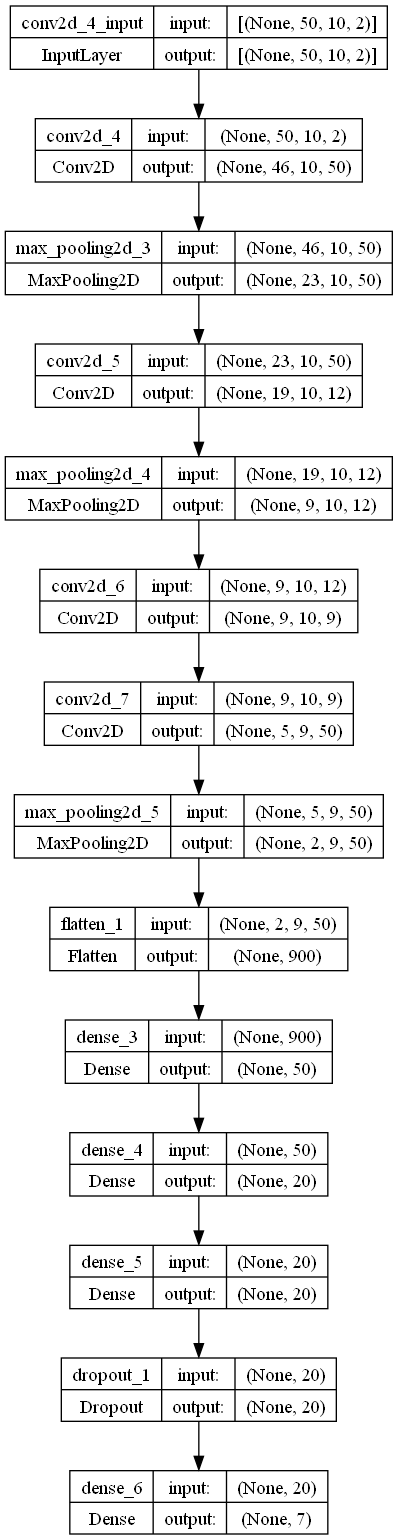

In [24]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [26]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [27]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [28]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [29]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [30]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 2s 23ms/step - loss: 10.9652 - a_1: 2.7919 - a_2: 2.8115 - b_1: 2.4914 - b_2: 2.6392 - d_1: 2.1191 - d_2: 2.4881 - n: 1.8542 - mean_metric: 0.5716 - val_loss: 9.4066 - val_a_1: 2.6830 - val_a_2: 2.6277 - val_b_1: 2.1981 - val_b_2: 2.3425 - val_d_1: 1.7197 - val_d_2: 2.3441 - val_n: 1.6608 - val_mean_metric: 0.5088 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 20ms/step - loss: 9.7954 - a_1: 2.7545 - a_2: 2.7813 - b_1: 2.3999 - b_2: 2.3626 - d_1: 1.7725 - d_2: 2.1086 - n: 1.7544 - mean_metric: 0.5297 - val_loss: 8.5032 - val_a_1: 2.6566 - val_a_2: 2.6265 - val_b_1: 2.0297 - val_b_2: 2.2411 - val_d_1: 1.5161 - val_d_2: 1.9024 - val_n: 1.5835 - val_mean_metric: 0.4755 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 20ms/step - loss: 9.0919 - a_1: 2.7368 - a_2: 2.7639 - b_1: 2.2715 - b_2: 2.2508 - d_1: 1.6197 - d_2: 1.8844 - n: 1.6511 - mean_metric: 0.5047 - val_loss: 7.8026 - val_a_1: 2.652

70/70 [==============================] - 1s 20ms/step - loss: 5.6380 - a_1: 2.6175 - a_2: 2.5756 - b_1: 1.5692 - b_2: 1.6887 - d_1: 1.0004 - d_2: 0.9878 - n: 1.4724 - mean_metric: 0.3961 - val_loss: 4.9903 - val_a_1: 2.5498 - val_a_2: 2.4972 - val_b_1: 1.4048 - val_b_2: 1.5149 - val_d_1: 0.5904 - val_d_2: 0.7055 - val_n: 1.4579 - val_mean_metric: 0.3502 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 1s 20ms/step - loss: 5.6251 - a_1: 2.6177 - a_2: 2.5841 - b_1: 1.5918 - b_2: 1.6725 - d_1: 0.9888 - d_2: 0.9690 - n: 1.4765 - mean_metric: 0.3957 - val_loss: 4.9791 - val_a_1: 2.5551 - val_a_2: 2.4935 - val_b_1: 1.4053 - val_b_2: 1.5867 - val_d_1: 0.5518 - val_d_2: 0.6342 - val_n: 1.4561 - val_mean_metric: 0.3489 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 1s 20ms/step - loss: 5.5976 - a_1: 2.6239 - a_2: 2.5822 - b_1: 1.5764 - b_2: 1.6749 - d_1: 0.9622 - d_2: 0.9638 - n: 1.4728 - mean_metric: 0.3942 - val_loss: 4.9686 - val_a_1: 2.5505 - val_a_2:

70/70 [==============================] - 1s 20ms/step - loss: 5.1453 - a_1: 2.5794 - a_2: 2.5096 - b_1: 1.4733 - b_2: 1.4771 - d_1: 0.9232 - d_2: 0.8932 - n: 1.4362 - mean_metric: 0.3754 - val_loss: 4.6790 - val_a_1: 2.5420 - val_a_2: 2.4261 - val_b_1: 1.5427 - val_b_2: 1.3874 - val_d_1: 0.5496 - val_d_2: 0.5808 - val_n: 1.4197 - val_mean_metric: 0.3412 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 20ms/step - loss: 5.1544 - a_1: 2.5889 - a_2: 2.5090 - b_1: 1.4830 - b_2: 1.4546 - d_1: 0.9314 - d_2: 0.9149 - n: 1.4347 - mean_metric: 0.3762 - val_loss: 4.5640 - val_a_1: 2.5187 - val_a_2: 2.4438 - val_b_1: 1.3478 - val_b_2: 1.3473 - val_d_1: 0.4995 - val_d_2: 0.6189 - val_n: 1.4194 - val_mean_metric: 0.3330 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 20ms/step - loss: 5.1340 - a_1: 2.5866 - a_2: 2.5096 - b_1: 1.4800 - b_2: 1.4623 - d_1: 0.9155 - d_2: 0.8988 - n: 1.4412 - mean_metric: 0.3755 - val_loss: 4.4751 - val_a_1: 2.5202 - val_a_2:

70/70 [==============================] - 1s 20ms/step - loss: 4.8551 - a_1: 2.5353 - a_2: 2.4261 - b_1: 1.4334 - b_2: 1.3607 - d_1: 0.8893 - d_2: 0.8453 - n: 1.4215 - mean_metric: 0.3628 - val_loss: 4.2993 - val_a_1: 2.4632 - val_a_2: 2.3830 - val_b_1: 1.3012 - val_b_2: 1.1895 - val_d_1: 0.5137 - val_d_2: 0.5770 - val_n: 1.4209 - val_mean_metric: 0.3217 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.8598 - a_1: 2.5359 - a_2: 2.4142 - b_1: 1.4398 - b_2: 1.3900 - d_1: 0.8850 - d_2: 0.8483 - n: 1.4197 - mean_metric: 0.3634 - val_loss: 4.2948 - val_a_1: 2.4528 - val_a_2: 2.3706 - val_b_1: 1.2927 - val_b_2: 1.2538 - val_d_1: 0.5233 - val_d_2: 0.5241 - val_n: 1.4155 - val_mean_metric: 0.3211 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.8656 - a_1: 2.5297 - a_2: 2.4067 - b_1: 1.4446 - b_2: 1.3647 - d_1: 0.8991 - d_2: 0.8708 - n: 1.4213 - mean_metric: 0.3636 - val_loss: 4.3185 - val_a_1: 2.4617 - val_a_2:

70/70 [==============================] - 1s 20ms/step - loss: 4.6958 - a_1: 2.4764 - a_2: 2.3468 - b_1: 1.4096 - b_2: 1.3472 - d_1: 0.8467 - d_2: 0.8376 - n: 1.4244 - mean_metric: 0.3553 - val_loss: 4.2014 - val_a_1: 2.4087 - val_a_2: 2.3081 - val_b_1: 1.3183 - val_b_2: 1.2236 - val_d_1: 0.5255 - val_d_2: 0.5187 - val_n: 1.4145 - val_mean_metric: 0.3174 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.6309 - a_1: 2.4733 - a_2: 2.3312 - b_1: 1.3888 - b_2: 1.3075 - d_1: 0.8444 - d_2: 0.8349 - n: 1.4212 - mean_metric: 0.3524 - val_loss: 4.1360 - val_a_1: 2.3796 - val_a_2: 2.3033 - val_b_1: 1.2485 - val_b_2: 1.2240 - val_d_1: 0.4943 - val_d_2: 0.5619 - val_n: 1.4149 - val_mean_metric: 0.3144 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.6354 - a_1: 2.4683 - a_2: 2.3258 - b_1: 1.3986 - b_2: 1.2979 - d_1: 0.8450 - d_2: 0.8318 - n: 1.4270 - mean_metric: 0.3522 - val_loss: 4.1891 - val_a_1: 2.3873 - val_a_2:

70/70 [==============================] - 1s 20ms/step - loss: 4.4854 - a_1: 2.4145 - a_2: 2.2096 - b_1: 1.3865 - b_2: 1.2535 - d_1: 0.8419 - d_2: 0.8281 - n: 1.4317 - mean_metric: 0.3445 - val_loss: 4.1850 - val_a_1: 2.3424 - val_a_2: 2.3651 - val_b_1: 1.3072 - val_b_2: 1.1539 - val_d_1: 0.5460 - val_d_2: 0.4911 - val_n: 1.4192 - val_mean_metric: 0.3143 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.4475 - a_1: 2.4070 - a_2: 2.2130 - b_1: 1.3766 - b_2: 1.2397 - d_1: 0.8155 - d_2: 0.8092 - n: 1.4318 - mean_metric: 0.3422 - val_loss: 4.1439 - val_a_1: 2.3417 - val_a_2: 2.3325 - val_b_1: 1.2764 - val_b_2: 1.1643 - val_d_1: 0.4918 - val_d_2: 0.5023 - val_n: 1.4192 - val_mean_metric: 0.3112 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.4287 - a_1: 2.4026 - a_2: 2.2029 - b_1: 1.3586 - b_2: 1.2306 - d_1: 0.8048 - d_2: 0.8267 - n: 1.4301 - mean_metric: 0.3409 - val_loss: 4.1521 - val_a_1: 2.3477 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 4.3047 - a_1: 2.3245 - a_2: 2.0600 - b_1: 1.3728 - b_2: 1.2296 - d_1: 0.8054 - d_2: 0.8266 - n: 1.4345 - mean_metric: 0.3343 - val_loss: 4.2160 - val_a_1: 2.3035 - val_a_2: 2.3801 - val_b_1: 1.3081 - val_b_2: 1.0996 - val_d_1: 0.4917 - val_d_2: 0.5022 - val_n: 1.4359 - val_mean_metric: 0.3110 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.2563 - a_1: 2.3379 - a_2: 2.0550 - b_1: 1.3596 - b_2: 1.1711 - d_1: 0.7861 - d_2: 0.8155 - n: 1.4311 - mean_metric: 0.3309 - val_loss: 4.2107 - val_a_1: 2.3575 - val_a_2: 2.3569 - val_b_1: 1.2622 - val_b_2: 1.1116 - val_d_1: 0.5384 - val_d_2: 0.4861 - val_n: 1.4406 - val_mean_metric: 0.3121 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.3292 - a_1: 2.3290 - a_2: 2.0852 - b_1: 1.3539 - b_2: 1.2477 - d_1: 0.8094 - d_2: 0.8255 - n: 1.4404 - mean_metric: 0.3355 - val_loss: 4.2301 - val_a_1: 2.3377 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 4.1838 - a_1: 2.2644 - a_2: 1.9586 - b_1: 1.3653 - b_2: 1.1876 - d_1: 0.7971 - d_2: 0.8172 - n: 1.4409 - mean_metric: 0.3268 - val_loss: 4.2897 - val_a_1: 2.3449 - val_a_2: 2.3846 - val_b_1: 1.2613 - val_b_2: 1.1347 - val_d_1: 0.4857 - val_d_2: 0.4935 - val_n: 1.4454 - val_mean_metric: 0.3120 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.1170 - a_1: 2.2372 - a_2: 1.9221 - b_1: 1.3298 - b_2: 1.1855 - d_1: 0.7841 - d_2: 0.8178 - n: 1.4406 - mean_metric: 0.3231 - val_loss: 4.2304 - val_a_1: 2.2958 - val_a_2: 2.3767 - val_b_1: 1.2817 - val_b_2: 1.1169 - val_d_1: 0.4749 - val_d_2: 0.4775 - val_n: 1.4450 - val_mean_metric: 0.3092 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.1197 - a_1: 2.2459 - a_2: 1.9166 - b_1: 1.3412 - b_2: 1.1991 - d_1: 0.7884 - d_2: 0.8055 - n: 1.4336 - mean_metric: 0.3234 - val_loss: 4.3045 - val_a_1: 2.3193 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 4.0361 - a_1: 2.1705 - a_2: 1.8427 - b_1: 1.3448 - b_2: 1.1519 - d_1: 0.8125 - d_2: 0.8025 - n: 1.4475 - mean_metric: 0.3182 - val_loss: 4.4397 - val_a_1: 2.3217 - val_a_2: 2.4368 - val_b_1: 1.3343 - val_b_2: 1.1610 - val_d_1: 0.4772 - val_d_2: 0.4929 - val_n: 1.4574 - val_mean_metric: 0.3163 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.0243 - a_1: 2.1679 - a_2: 1.8253 - b_1: 1.3273 - b_2: 1.1902 - d_1: 0.7861 - d_2: 0.8269 - n: 1.4440 - mean_metric: 0.3180 - val_loss: 4.4661 - val_a_1: 2.3410 - val_a_2: 2.4659 - val_b_1: 1.3096 - val_b_2: 1.1510 - val_d_1: 0.4729 - val_d_2: 0.5086 - val_n: 1.4566 - val_mean_metric: 0.3170 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 1s 20ms/step - loss: 4.0157 - a_1: 2.1634 - a_2: 1.8716 - b_1: 1.3174 - b_2: 1.1428 - d_1: 0.7890 - d_2: 0.8215 - n: 1.4458 - mean_metric: 0.3175 - val_loss: 4.4491 - val_a_1: 2.3237 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.9579 - a_1: 2.0922 - a_2: 1.7950 - b_1: 1.3233 - b_2: 1.1582 - d_1: 0.8104 - d_2: 0.8227 - n: 1.4541 - mean_metric: 0.3143 - val_loss: 4.5057 - val_a_1: 2.3557 - val_a_2: 2.4640 - val_b_1: 1.2963 - val_b_2: 1.1508 - val_d_1: 0.4909 - val_d_2: 0.4728 - val_n: 1.4623 - val_mean_metric: 0.3167 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.9098 - a_1: 2.0789 - a_2: 1.7685 - b_1: 1.3221 - b_2: 1.1358 - d_1: 0.8056 - d_2: 0.8051 - n: 1.4475 - mean_metric: 0.3112 - val_loss: 4.4828 - val_a_1: 2.3376 - val_a_2: 2.4478 - val_b_1: 1.2935 - val_b_2: 1.1364 - val_d_1: 0.4916 - val_d_2: 0.5005 - val_n: 1.4578 - val_mean_metric: 0.3158 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.8700 - a_1: 2.0607 - a_2: 1.7640 - b_1: 1.2841 - b_2: 1.1561 - d_1: 0.8151 - d_2: 0.7953 - n: 1.4484 - mean_metric: 0.3099 - val_loss: 4.4860 - val_a_1: 2.3433 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.8596 - a_1: 2.0344 - a_2: 1.7352 - b_1: 1.3224 - b_2: 1.1378 - d_1: 0.8338 - d_2: 0.7879 - n: 1.4492 - mean_metric: 0.3092 - val_loss: 4.6608 - val_a_1: 2.3584 - val_a_2: 2.5317 - val_b_1: 1.3274 - val_b_2: 1.1731 - val_d_1: 0.4922 - val_d_2: 0.5036 - val_n: 1.4605 - val_mean_metric: 0.3216 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.8348 - a_1: 2.0234 - a_2: 1.7541 - b_1: 1.3079 - b_2: 1.1113 - d_1: 0.8243 - d_2: 0.7822 - n: 1.4526 - mean_metric: 0.3077 - val_loss: 4.6036 - val_a_1: 2.3226 - val_a_2: 2.5112 - val_b_1: 1.3168 - val_b_2: 1.1579 - val_d_1: 0.4717 - val_d_2: 0.5471 - val_n: 1.4596 - val_mean_metric: 0.3197 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.8566 - a_1: 2.0078 - a_2: 1.7460 - b_1: 1.3169 - b_2: 1.1260 - d_1: 0.8445 - d_2: 0.8109 - n: 1.4507 - mean_metric: 0.3092 - val_loss: 4.6727 - val_a_1: 2.3525 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.8341 - a_1: 1.9790 - a_2: 1.6921 - b_1: 1.3012 - b_2: 1.1336 - d_1: 0.8518 - d_2: 0.8223 - n: 1.4575 - mean_metric: 0.3072 - val_loss: 4.8313 - val_a_1: 2.3761 - val_a_2: 2.5670 - val_b_1: 1.4215 - val_b_2: 1.1697 - val_d_1: 0.4686 - val_d_2: 0.5323 - val_n: 1.4560 - val_mean_metric: 0.3264 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.8132 - a_1: 1.9805 - a_2: 1.6911 - b_1: 1.3095 - b_2: 1.1218 - d_1: 0.8493 - d_2: 0.7936 - n: 1.4568 - mean_metric: 0.3060 - val_loss: 4.7725 - val_a_1: 2.3732 - val_a_2: 2.5591 - val_b_1: 1.3524 - val_b_2: 1.1687 - val_d_1: 0.5236 - val_d_2: 0.5093 - val_n: 1.4549 - val_mean_metric: 0.3248 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.8080 - a_1: 2.0247 - a_2: 1.6581 - b_1: 1.3001 - b_2: 1.1221 - d_1: 0.8552 - d_2: 0.7999 - n: 1.4529 - mean_metric: 0.3063 - val_loss: 4.7746 - val_a_1: 2.4175 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.7390 - a_1: 1.9288 - a_2: 1.6201 - b_1: 1.2944 - b_2: 1.1165 - d_1: 0.8747 - d_2: 0.8015 - n: 1.4542 - mean_metric: 0.3022 - val_loss: 4.8607 - val_a_1: 2.4274 - val_a_2: 2.5756 - val_b_1: 1.3306 - val_b_2: 1.1572 - val_d_1: 0.5023 - val_d_2: 0.5027 - val_n: 1.4597 - val_mean_metric: 0.3253 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.7130 - a_1: 1.9462 - a_2: 1.6326 - b_1: 1.2844 - b_2: 1.0893 - d_1: 0.8608 - d_2: 0.8098 - n: 1.4605 - mean_metric: 0.3020 - val_loss: 4.8163 - val_a_1: 2.4172 - val_a_2: 2.5800 - val_b_1: 1.3350 - val_b_2: 1.1580 - val_d_1: 0.4852 - val_d_2: 0.5199 - val_n: 1.4581 - val_mean_metric: 0.3251 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.6959 - a_1: 1.9376 - a_2: 1.6074 - b_1: 1.2944 - b_2: 1.0861 - d_1: 0.8752 - d_2: 0.7864 - n: 1.4525 - mean_metric: 0.3005 - val_loss: 4.8287 - val_a_1: 2.4456 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.7120 - a_1: 1.8973 - a_2: 1.5826 - b_1: 1.3024 - b_2: 1.1122 - d_1: 0.9119 - d_2: 0.8105 - n: 1.4604 - mean_metric: 0.3018 - val_loss: 4.9888 - val_a_1: 2.4345 - val_a_2: 2.6086 - val_b_1: 1.4131 - val_b_2: 1.1887 - val_d_1: 0.5012 - val_d_2: 0.5108 - val_n: 1.4629 - val_mean_metric: 0.3305 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.6888 - a_1: 1.9069 - a_2: 1.5595 - b_1: 1.2764 - b_2: 1.0832 - d_1: 0.9163 - d_2: 0.8039 - n: 1.4537 - mean_metric: 0.2992 - val_loss: 4.9475 - val_a_1: 2.4756 - val_a_2: 2.6008 - val_b_1: 1.3928 - val_b_2: 1.1814 - val_d_1: 0.5241 - val_d_2: 0.4810 - val_n: 1.4598 - val_mean_metric: 0.3304 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.6632 - a_1: 1.8872 - a_2: 1.5696 - b_1: 1.2862 - b_2: 1.1047 - d_1: 0.9029 - d_2: 0.7769 - n: 1.4586 - mean_metric: 0.2987 - val_loss: 4.9609 - val_a_1: 2.4252 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.5908 - a_1: 1.8610 - a_2: 1.4957 - b_1: 1.2791 - b_2: 1.0960 - d_1: 0.9227 - d_2: 0.7571 - n: 1.4554 - mean_metric: 0.2948 - val_loss: 5.0222 - val_a_1: 2.4708 - val_a_2: 2.6156 - val_b_1: 1.3756 - val_b_2: 1.1661 - val_d_1: 0.6199 - val_d_2: 0.4950 - val_n: 1.4610 - val_mean_metric: 0.3334 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.6066 - a_1: 1.8787 - a_2: 1.4995 - b_1: 1.2825 - b_2: 1.0887 - d_1: 0.9223 - d_2: 0.7755 - n: 1.4579 - mean_metric: 0.2960 - val_loss: 5.0412 - val_a_1: 2.4575 - val_a_2: 2.6666 - val_b_1: 1.4038 - val_b_2: 1.1669 - val_d_1: 0.5714 - val_d_2: 0.5186 - val_n: 1.4635 - val_mean_metric: 0.3348 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.6155 - a_1: 1.8765 - a_2: 1.5003 - b_1: 1.2893 - b_2: 1.0927 - d_1: 0.9192 - d_2: 0.7856 - n: 1.4575 - mean_metric: 0.2965 - val_loss: 5.0918 - val_a_1: 2.4827 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.6051 - a_1: 1.8643 - a_2: 1.4654 - b_1: 1.2732 - b_2: 1.0930 - d_1: 0.9287 - d_2: 0.7962 - n: 1.4612 - mean_metric: 0.2953 - val_loss: 5.1290 - val_a_1: 2.4833 - val_a_2: 2.6856 - val_b_1: 1.3925 - val_b_2: 1.1658 - val_d_1: 0.5644 - val_d_2: 0.5209 - val_n: 1.4686 - val_mean_metric: 0.3359 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5982 - a_1: 1.8330 - a_2: 1.4940 - b_1: 1.3027 - b_2: 1.0801 - d_1: 0.9074 - d_2: 0.7879 - n: 1.4604 - mean_metric: 0.2947 - val_loss: 5.1021 - val_a_1: 2.4990 - val_a_2: 2.6279 - val_b_1: 1.3894 - val_b_2: 1.1818 - val_d_1: 0.5350 - val_d_2: 0.5372 - val_n: 1.4648 - val_mean_metric: 0.3343 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5637 - a_1: 1.8300 - a_2: 1.4654 - b_1: 1.2785 - b_2: 1.0829 - d_1: 0.9150 - d_2: 0.7856 - n: 1.4637 - mean_metric: 0.2932 - val_loss: 5.2011 - val_a_1: 2.4810 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.5249 - a_1: 1.8149 - a_2: 1.4635 - b_1: 1.2368 - b_2: 1.0864 - d_1: 0.9040 - d_2: 0.7770 - n: 1.4594 - mean_metric: 0.2907 - val_loss: 5.2138 - val_a_1: 2.5248 - val_a_2: 2.6908 - val_b_1: 1.4507 - val_b_2: 1.2183 - val_d_1: 0.5937 - val_d_2: 0.5126 - val_n: 1.4648 - val_mean_metric: 0.3416 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5787 - a_1: 1.8192 - a_2: 1.4866 - b_1: 1.2843 - b_2: 1.1153 - d_1: 0.8733 - d_2: 0.7867 - n: 1.4592 - mean_metric: 0.2933 - val_loss: 5.0827 - val_a_1: 2.5228 - val_a_2: 2.6391 - val_b_1: 1.3955 - val_b_2: 1.1715 - val_d_1: 0.5721 - val_d_2: 0.4665 - val_n: 1.4634 - val_mean_metric: 0.3343 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5195 - a_1: 1.8069 - a_2: 1.4559 - b_1: 1.2661 - b_2: 1.0774 - d_1: 0.8875 - d_2: 0.7669 - n: 1.4570 - mean_metric: 0.2898 - val_loss: 5.0964 - val_a_1: 2.5103 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.5501 - a_1: 1.8131 - a_2: 1.4494 - b_1: 1.2722 - b_2: 1.0859 - d_1: 0.8746 - d_2: 0.7783 - n: 1.4634 - mean_metric: 0.2905 - val_loss: 5.2366 - val_a_1: 2.5348 - val_a_2: 2.6549 - val_b_1: 1.4527 - val_b_2: 1.2050 - val_d_1: 0.6374 - val_d_2: 0.4757 - val_n: 1.4659 - val_mean_metric: 0.3407 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5312 - a_1: 1.7981 - a_2: 1.4583 - b_1: 1.2679 - b_2: 1.0945 - d_1: 0.8765 - d_2: 0.7739 - n: 1.4601 - mean_metric: 0.2902 - val_loss: 5.1590 - val_a_1: 2.4968 - val_a_2: 2.6923 - val_b_1: 1.4003 - val_b_2: 1.2137 - val_d_1: 0.5722 - val_d_2: 0.4960 - val_n: 1.4661 - val_mean_metric: 0.3377 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.5145 - a_1: 1.7927 - a_2: 1.4431 - b_1: 1.2855 - b_2: 1.0825 - d_1: 0.8594 - d_2: 0.7743 - n: 1.4582 - mean_metric: 0.2890 - val_loss: 5.1904 - val_a_1: 2.5147 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.4465 - a_1: 1.7617 - a_2: 1.4257 - b_1: 1.2501 - b_2: 1.0607 - d_1: 0.8336 - d_2: 0.7777 - n: 1.4603 - mean_metric: 0.2849 - val_loss: 5.1821 - val_a_1: 2.5179 - val_a_2: 2.6904 - val_b_1: 1.4213 - val_b_2: 1.1648 - val_d_1: 0.5393 - val_d_2: 0.4666 - val_n: 1.4640 - val_mean_metric: 0.3354 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4817 - a_1: 1.7741 - a_2: 1.4416 - b_1: 1.2581 - b_2: 1.0705 - d_1: 0.8418 - d_2: 0.7767 - n: 1.4574 - mean_metric: 0.2866 - val_loss: 5.1870 - val_a_1: 2.5651 - val_a_2: 2.6382 - val_b_1: 1.4047 - val_b_2: 1.2325 - val_d_1: 0.5169 - val_d_2: 0.4844 - val_n: 1.4631 - val_mean_metric: 0.3367 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4906 - a_1: 1.7657 - a_2: 1.4357 - b_1: 1.2579 - b_2: 1.0840 - d_1: 0.8642 - d_2: 0.7797 - n: 1.4570 - mean_metric: 0.2874 - val_loss: 5.1550 - val_a_1: 2.5469 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.4170 - a_1: 1.7278 - a_2: 1.4072 - b_1: 1.2419 - b_2: 1.0849 - d_1: 0.8416 - d_2: 0.7739 - n: 1.4623 - mean_metric: 0.2839 - val_loss: 5.3534 - val_a_1: 2.5740 - val_a_2: 2.7097 - val_b_1: 1.5015 - val_b_2: 1.2085 - val_d_1: 0.5757 - val_d_2: 0.4673 - val_n: 1.4691 - val_mean_metric: 0.3432 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4839 - a_1: 1.7582 - a_2: 1.4026 - b_1: 1.3012 - b_2: 1.0910 - d_1: 0.8551 - d_2: 0.7776 - n: 1.4564 - mean_metric: 0.2872 - val_loss: 5.1353 - val_a_1: 2.5654 - val_a_2: 2.6519 - val_b_1: 1.4255 - val_b_2: 1.1558 - val_d_1: 0.5347 - val_d_2: 0.4674 - val_n: 1.4681 - val_mean_metric: 0.3355 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4123 - a_1: 1.7421 - a_2: 1.4055 - b_1: 1.2460 - b_2: 1.0677 - d_1: 0.8389 - d_2: 0.7689 - n: 1.4608 - mean_metric: 0.2836 - val_loss: 5.2622 - val_a_1: 2.5688 - val_a_

70/70 [==============================] - 1s 20ms/step - loss: 3.3580 - a_1: 1.6917 - a_2: 1.3731 - b_1: 1.2520 - b_2: 1.0710 - d_1: 0.8043 - d_2: 0.7747 - n: 1.4627 - mean_metric: 0.2802 - val_loss: 5.2360 - val_a_1: 2.5588 - val_a_2: 2.7281 - val_b_1: 1.3921 - val_b_2: 1.1558 - val_d_1: 0.5209 - val_d_2: 0.4882 - val_n: 1.4605 - val_mean_metric: 0.3367 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4161 - a_1: 1.7304 - a_2: 1.3872 - b_1: 1.2543 - b_2: 1.0916 - d_1: 0.8242 - d_2: 0.7657 - n: 1.4588 - mean_metric: 0.2830 - val_loss: 5.1849 - val_a_1: 2.5503 - val_a_2: 2.6857 - val_b_1: 1.3764 - val_b_2: 1.1913 - val_d_1: 0.4824 - val_d_2: 0.4737 - val_n: 1.4651 - val_mean_metric: 0.3340 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.4263 - a_1: 1.7568 - a_2: 1.4010 - b_1: 1.2439 - b_2: 1.0700 - d_1: 0.8589 - d_2: 0.7485 - n: 1.4635 - mean_metric: 0.2840 - val_loss: 5.1778 - val_a_1: 2.5640 

70/70 [==============================] - 1s 20ms/step - loss: 3.3848 - a_1: 1.7249 - a_2: 1.3888 - b_1: 1.2360 - b_2: 1.0816 - d_1: 0.8290 - d_2: 0.7485 - n: 1.4629 - mean_metric: 0.2817 - val_loss: 5.2733 - val_a_1: 2.6038 - val_a_2: 2.7076 - val_b_1: 1.3753 - val_b_2: 1.2113 - val_d_1: 0.5173 - val_d_2: 0.4753 - val_n: 1.4672 - val_mean_metric: 0.3384 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.3614 - a_1: 1.7064 - a_2: 1.3788 - b_1: 1.2368 - b_2: 1.0570 - d_1: 0.8402 - d_2: 0.7552 - n: 1.4614 - mean_metric: 0.2805 - val_loss: 5.2612 - val_a_1: 2.5776 - val_a_2: 2.7304 - val_b_1: 1.3884 - val_b_2: 1.1498 - val_d_1: 0.5307 - val_d_2: 0.4798 - val_n: 1.4671 - val_mean_metric: 0.3373 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.3613 - a_1: 1.6816 - a_2: 1.4095 - b_1: 1.2450 - b_2: 1.0613 - d_1: 0.8374 - d_2: 0.7458 - n: 1.4627 - mean_metric: 0.2807 - val_loss: 5.2219 - val_a_1: 2.5613 

70/70 [==============================] - 1s 20ms/step - loss: 3.3221 - a_1: 1.6944 - a_2: 1.3386 - b_1: 1.2337 - b_2: 1.0561 - d_1: 0.8453 - d_2: 0.7462 - n: 1.4568 - mean_metric: 0.2782 - val_loss: 5.2567 - val_a_1: 2.5445 - val_a_2: 2.7445 - val_b_1: 1.3806 - val_b_2: 1.2115 - val_d_1: 0.5189 - val_d_2: 0.4482 - val_n: 1.4632 - val_mean_metric: 0.3368 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.3656 - a_1: 1.6992 - a_2: 1.3704 - b_1: 1.2484 - b_2: 1.0673 - d_1: 0.8211 - d_2: 0.7519 - n: 1.4644 - mean_metric: 0.2801 - val_loss: 5.2935 - val_a_1: 2.5565 - val_a_2: 2.7357 - val_b_1: 1.4267 - val_b_2: 1.2789 - val_d_1: 0.4964 - val_d_2: 0.4749 - val_n: 1.4615 - val_mean_metric: 0.3408 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.3111 - a_1: 1.6745 - a_2: 1.3765 - b_1: 1.2252 - b_2: 1.0532 - d_1: 0.8276 - d_2: 0.7370 - n: 1.4597 - mean_metric: 0.2777 - val_loss: 5.2347 - val_a_1: 2.5739 

70/70 [==============================] - 1s 20ms/step - loss: 3.2876 - a_1: 1.6331 - a_2: 1.3387 - b_1: 1.2396 - b_2: 1.0469 - d_1: 0.8325 - d_2: 0.7421 - n: 1.4586 - mean_metric: 0.2756 - val_loss: 5.2594 - val_a_1: 2.5844 - val_a_2: 2.7420 - val_b_1: 1.4173 - val_b_2: 1.1780 - val_d_1: 0.5203 - val_d_2: 0.4599 - val_n: 1.4631 - val_mean_metric: 0.3386 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2768 - a_1: 1.6282 - a_2: 1.3491 - b_1: 1.2311 - b_2: 1.0603 - d_1: 0.8315 - d_2: 0.7484 - n: 1.4580 - mean_metric: 0.2761 - val_loss: 5.2503 - val_a_1: 2.5707 - val_a_2: 2.7428 - val_b_1: 1.3959 - val_b_2: 1.1568 - val_d_1: 0.4954 - val_d_2: 0.4627 - val_n: 1.4638 - val_mean_metric: 0.3361 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2647 - a_1: 1.6461 - a_2: 1.3389 - b_1: 1.2257 - b_2: 1.0500 - d_1: 0.8252 - d_2: 0.7379 - n: 1.4632 - mean_metric: 0.2755 - val_loss: 5.2820 - val_a_1: 2.5841 

70/70 [==============================] - 1s 20ms/step - loss: 3.2532 - a_1: 1.5982 - a_2: 1.3389 - b_1: 1.2303 - b_2: 1.0652 - d_1: 0.8381 - d_2: 0.7419 - n: 1.4610 - mean_metric: 0.2750 - val_loss: 5.3507 - val_a_1: 2.6049 - val_a_2: 2.7400 - val_b_1: 1.4071 - val_b_2: 1.2303 - val_d_1: 0.5108 - val_d_2: 0.4949 - val_n: 1.4604 - val_mean_metric: 0.3413 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2767 - a_1: 1.6546 - a_2: 1.3328 - b_1: 1.2276 - b_2: 1.0493 - d_1: 0.8308 - d_2: 0.7411 - n: 1.4632 - mean_metric: 0.2759 - val_loss: 5.3086 - val_a_1: 2.5577 - val_a_2: 2.7474 - val_b_1: 1.4335 - val_b_2: 1.1782 - val_d_1: 0.5146 - val_d_2: 0.4632 - val_n: 1.4620 - val_mean_metric: 0.3383 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2853 - a_1: 1.6491 - a_2: 1.3479 - b_1: 1.2228 - b_2: 1.0765 - d_1: 0.8080 - d_2: 0.7460 - n: 1.4651 - mean_metric: 0.2765 - val_loss: 5.3298 - val_a_1: 2.5895 

70/70 [==============================] - 1s 20ms/step - loss: 3.2393 - a_1: 1.6150 - a_2: 1.3023 - b_1: 1.2244 - b_2: 1.0582 - d_1: 0.8234 - d_2: 0.7304 - n: 1.4609 - mean_metric: 0.2731 - val_loss: 5.3602 - val_a_1: 2.6285 - val_a_2: 2.7610 - val_b_1: 1.4018 - val_b_2: 1.1711 - val_d_1: 0.5379 - val_d_2: 0.4706 - val_n: 1.4623 - val_mean_metric: 0.3409 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2242 - a_1: 1.6185 - a_2: 1.3386 - b_1: 1.2177 - b_2: 1.0416 - d_1: 0.8241 - d_2: 0.7315 - n: 1.4585 - mean_metric: 0.2737 - val_loss: 5.3663 - val_a_1: 2.6191 - val_a_2: 2.7392 - val_b_1: 1.4262 - val_b_2: 1.1458 - val_d_1: 0.5822 - val_d_2: 0.4654 - val_n: 1.4605 - val_mean_metric: 0.3409 - lr: 7.9210e-04
Epoch 528/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2355 - a_1: 1.6263 - a_2: 1.3277 - b_1: 1.2263 - b_2: 1.0381 - d_1: 0.8144 - d_2: 0.7301 - n: 1.4611 - mean_metric: 0.2735 - val_loss: 5.3528 - val_a_1: 2.6256 

70/70 [==============================] - 1s 20ms/step - loss: 3.2286 - a_1: 1.6157 - a_2: 1.3200 - b_1: 1.2059 - b_2: 1.0558 - d_1: 0.8272 - d_2: 0.7359 - n: 1.4630 - mean_metric: 0.2734 - val_loss: 5.3678 - val_a_1: 2.6380 - val_a_2: 2.7525 - val_b_1: 1.4003 - val_b_2: 1.1740 - val_d_1: 0.5251 - val_d_2: 0.4635 - val_n: 1.4628 - val_mean_metric: 0.3402 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1994 - a_1: 1.6030 - a_2: 1.3055 - b_1: 1.1974 - b_2: 1.0582 - d_1: 0.8046 - d_2: 0.7336 - n: 1.4641 - mean_metric: 0.2715 - val_loss: 5.3418 - val_a_1: 2.6228 - val_a_2: 2.7275 - val_b_1: 1.4129 - val_b_2: 1.1592 - val_d_1: 0.5398 - val_d_2: 0.4706 - val_n: 1.4617 - val_mean_metric: 0.3395 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1712 - a_1: 1.5947 - a_2: 1.2713 - b_1: 1.2015 - b_2: 1.0601 - d_1: 0.8193 - d_2: 0.7291 - n: 1.4608 - mean_metric: 0.2705 - val_loss: 5.3634 - val_a_1: 2.6323 

70/70 [==============================] - 1s 20ms/step - loss: 3.1722 - a_1: 1.6081 - a_2: 1.3070 - b_1: 1.2008 - b_2: 1.0459 - d_1: 0.8101 - d_2: 0.7186 - n: 1.4634 - mean_metric: 0.2711 - val_loss: 5.3518 - val_a_1: 2.6585 - val_a_2: 2.7693 - val_b_1: 1.4003 - val_b_2: 1.1667 - val_d_1: 0.5126 - val_d_2: 0.4416 - val_n: 1.4591 - val_mean_metric: 0.3398 - lr: 7.2445e-04
Epoch 569/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1685 - a_1: 1.5612 - a_2: 1.2826 - b_1: 1.2228 - b_2: 1.0392 - d_1: 0.8308 - d_2: 0.7294 - n: 1.4661 - mean_metric: 0.2704 - val_loss: 5.4521 - val_a_1: 2.6624 - val_a_2: 2.8047 - val_b_1: 1.3901 - val_b_2: 1.1640 - val_d_1: 0.5526 - val_d_2: 0.4748 - val_n: 1.4619 - val_mean_metric: 0.3433 - lr: 7.2280e-04
Epoch 570/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.2004 - a_1: 1.5764 - a_2: 1.3302 - b_1: 1.2117 - b_2: 1.0613 - d_1: 0.8117 - d_2: 0.7263 - n: 1.4625 - mean_metric: 0.2719 - val_loss: 5.3785 - val_a_1: 2.6640 

70/70 [==============================] - 1s 20ms/step - loss: 3.1492 - a_1: 1.5480 - a_2: 1.2578 - b_1: 1.2179 - b_2: 1.0448 - d_1: 0.8069 - d_2: 0.7487 - n: 1.4631 - mean_metric: 0.2688 - val_loss: 5.4003 - val_a_1: 2.6592 - val_a_2: 2.7544 - val_b_1: 1.4353 - val_b_2: 1.1704 - val_d_1: 0.5060 - val_d_2: 0.4466 - val_n: 1.4621 - val_mean_metric: 0.3408 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1608 - a_1: 1.5706 - a_2: 1.3135 - b_1: 1.1934 - b_2: 1.0452 - d_1: 0.8165 - d_2: 0.7259 - n: 1.4626 - mean_metric: 0.2702 - val_loss: 5.4152 - val_a_1: 2.6548 - val_a_2: 2.7864 - val_b_1: 1.4223 - val_b_2: 1.1731 - val_d_1: 0.5047 - val_d_2: 0.4480 - val_n: 1.4636 - val_mean_metric: 0.3414 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1530 - a_1: 1.5612 - a_2: 1.2964 - b_1: 1.1851 - b_2: 1.0352 - d_1: 0.8095 - d_2: 0.7366 - n: 1.4583 - mean_metric: 0.2688 - val_loss: 5.3822 - val_a_1: 2.6522 

70/70 [==============================] - 1s 20ms/step - loss: 3.1073 - a_1: 1.5459 - a_2: 1.2685 - b_1: 1.1771 - b_2: 1.0273 - d_1: 0.8240 - d_2: 0.7258 - n: 1.4618 - mean_metric: 0.2670 - val_loss: 5.4213 - val_a_1: 2.6766 - val_a_2: 2.7957 - val_b_1: 1.3998 - val_b_2: 1.1599 - val_d_1: 0.5319 - val_d_2: 0.4293 - val_n: 1.4580 - val_mean_metric: 0.3414 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1295 - a_1: 1.5389 - a_2: 1.2767 - b_1: 1.2103 - b_2: 1.0398 - d_1: 0.8271 - d_2: 0.7293 - n: 1.4582 - mean_metric: 0.2686 - val_loss: 5.4684 - val_a_1: 2.6812 - val_a_2: 2.7896 - val_b_1: 1.4165 - val_b_2: 1.1916 - val_d_1: 0.5477 - val_d_2: 0.4400 - val_n: 1.4610 - val_mean_metric: 0.3439 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1168 - a_1: 1.5626 - a_2: 1.2683 - b_1: 1.1823 - b_2: 1.0283 - d_1: 0.8144 - d_2: 0.7189 - n: 1.4662 - mean_metric: 0.2673 - val_loss: 5.3990 - val_a_1: 2.6597 

70/70 [==============================] - 1s 20ms/step - loss: 3.1091 - a_1: 1.5122 - a_2: 1.2719 - b_1: 1.2159 - b_2: 1.0427 - d_1: 0.8107 - d_2: 0.7257 - n: 1.4632 - mean_metric: 0.2673 - val_loss: 5.4161 - val_a_1: 2.6572 - val_a_2: 2.8029 - val_b_1: 1.3877 - val_b_2: 1.1744 - val_d_1: 0.5058 - val_d_2: 0.4475 - val_n: 1.4617 - val_mean_metric: 0.3409 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.1177 - a_1: 1.5149 - a_2: 1.2773 - b_1: 1.1871 - b_2: 1.0412 - d_1: 0.8331 - d_2: 0.7435 - n: 1.4627 - mean_metric: 0.2679 - val_loss: 5.4289 - val_a_1: 2.6823 - val_a_2: 2.8000 - val_b_1: 1.4077 - val_b_2: 1.1600 - val_d_1: 0.5272 - val_d_2: 0.4395 - val_n: 1.4609 - val_mean_metric: 0.3422 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0892 - a_1: 1.5235 - a_2: 1.2801 - b_1: 1.1908 - b_2: 1.0180 - d_1: 0.8088 - d_2: 0.7076 - n: 1.4611 - mean_metric: 0.2656 - val_loss: 5.4416 - val_a_1: 2.6800 

70/70 [==============================] - 1s 20ms/step - loss: 3.1106 - a_1: 1.5502 - a_2: 1.2620 - b_1: 1.2155 - b_2: 1.0386 - d_1: 0.8070 - d_2: 0.7149 - n: 1.4633 - mean_metric: 0.2677 - val_loss: 5.4874 - val_a_1: 2.7383 - val_a_2: 2.7845 - val_b_1: 1.4263 - val_b_2: 1.1732 - val_d_1: 0.4951 - val_d_2: 0.4475 - val_n: 1.4575 - val_mean_metric: 0.3437 - lr: 5.8585e-04
Epoch 653/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0900 - a_1: 1.5155 - a_2: 1.2816 - b_1: 1.1618 - b_2: 1.0368 - d_1: 0.8047 - d_2: 0.7360 - n: 1.4648 - mean_metric: 0.2660 - val_loss: 5.5501 - val_a_1: 2.7162 - val_a_2: 2.8053 - val_b_1: 1.4685 - val_b_2: 1.1870 - val_d_1: 0.5227 - val_d_2: 0.4560 - val_n: 1.4608 - val_mean_metric: 0.3468 - lr: 5.8420e-04
Epoch 654/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0524 - a_1: 1.5127 - a_2: 1.2471 - b_1: 1.1724 - b_2: 1.0496 - d_1: 0.8156 - d_2: 0.7271 - n: 1.4650 - mean_metric: 0.2656 - val_loss: 5.4692 - val_a_1: 2.6964 

70/70 [==============================] - 1s 20ms/step - loss: 3.0826 - a_1: 1.5362 - a_2: 1.2567 - b_1: 1.1982 - b_2: 1.0432 - d_1: 0.8052 - d_2: 0.7156 - n: 1.4667 - mean_metric: 0.2667 - val_loss: 5.5137 - val_a_1: 2.7366 - val_a_2: 2.7840 - val_b_1: 1.4218 - val_b_2: 1.1960 - val_d_1: 0.5066 - val_d_2: 0.4428 - val_n: 1.4609 - val_mean_metric: 0.3446 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0886 - a_1: 1.5094 - a_2: 1.2534 - b_1: 1.1895 - b_2: 1.0525 - d_1: 0.8394 - d_2: 0.7177 - n: 1.4640 - mean_metric: 0.2668 - val_loss: 5.5832 - val_a_1: 2.7288 - val_a_2: 2.8150 - val_b_1: 1.4481 - val_b_2: 1.2083 - val_d_1: 0.5498 - val_d_2: 0.4663 - val_n: 1.4594 - val_mean_metric: 0.3488 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0648 - a_1: 1.5228 - a_2: 1.2509 - b_1: 1.1677 - b_2: 1.0661 - d_1: 0.8169 - d_2: 0.7215 - n: 1.4623 - mean_metric: 0.2662 - val_loss: 5.5050 - val_a_1: 2.7372 

70/70 [==============================] - 1s 20ms/step - loss: 3.1077 - a_1: 1.5101 - a_2: 1.2554 - b_1: 1.2060 - b_2: 1.0643 - d_1: 0.7998 - d_2: 0.7503 - n: 1.4631 - mean_metric: 0.2675 - val_loss: 5.6033 - val_a_1: 2.7654 - val_a_2: 2.8219 - val_b_1: 1.4531 - val_b_2: 1.1899 - val_d_1: 0.5195 - val_d_2: 0.4522 - val_n: 1.4579 - val_mean_metric: 0.3482 - lr: 5.1655e-04
Epoch 695/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0673 - a_1: 1.5003 - a_2: 1.2601 - b_1: 1.1793 - b_2: 1.0560 - d_1: 0.8001 - d_2: 0.7277 - n: 1.4609 - mean_metric: 0.2654 - val_loss: 5.5347 - val_a_1: 2.7513 - val_a_2: 2.7754 - val_b_1: 1.4498 - val_b_2: 1.1950 - val_d_1: 0.4881 - val_d_2: 0.4488 - val_n: 1.4581 - val_mean_metric: 0.3452 - lr: 5.1490e-04
Epoch 696/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0309 - a_1: 1.5160 - a_2: 1.2304 - b_1: 1.1529 - b_2: 1.0211 - d_1: 0.8018 - d_2: 0.7430 - n: 1.4636 - mean_metric: 0.2636 - val_loss: 5.5947 - val_a_1: 2.7670 

70/70 [==============================] - 1s 20ms/step - loss: 3.0520 - a_1: 1.5039 - a_2: 1.2437 - b_1: 1.1711 - b_2: 1.0449 - d_1: 0.8072 - d_2: 0.7338 - n: 1.4672 - mean_metric: 0.2650 - val_loss: 5.6245 - val_a_1: 2.7678 - val_a_2: 2.8072 - val_b_1: 1.4694 - val_b_2: 1.1888 - val_d_1: 0.5025 - val_d_2: 0.4477 - val_n: 1.4595 - val_mean_metric: 0.3476 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0315 - a_1: 1.4941 - a_2: 1.2312 - b_1: 1.1606 - b_2: 1.0483 - d_1: 0.8010 - d_2: 0.7226 - n: 1.4660 - mean_metric: 0.2634 - val_loss: 5.5470 - val_a_1: 2.7313 - val_a_2: 2.8127 - val_b_1: 1.4649 - val_b_2: 1.1869 - val_d_1: 0.4805 - val_d_2: 0.4303 - val_n: 1.4578 - val_mean_metric: 0.3451 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0228 - a_1: 1.4959 - a_2: 1.2113 - b_1: 1.1961 - b_2: 1.0370 - d_1: 0.8148 - d_2: 0.7061 - n: 1.4642 - mean_metric: 0.2634 - val_loss: 5.5652 - val_a_1: 2.7595 

70/70 [==============================] - 1s 20ms/step - loss: 3.0153 - a_1: 1.4977 - a_2: 1.2302 - b_1: 1.1791 - b_2: 1.0420 - d_1: 0.7969 - d_2: 0.7097 - n: 1.4679 - mean_metric: 0.2633 - val_loss: 5.6050 - val_a_1: 2.7593 - val_a_2: 2.8073 - val_b_1: 1.5202 - val_b_2: 1.1937 - val_d_1: 0.4890 - val_d_2: 0.4361 - val_n: 1.4582 - val_mean_metric: 0.3483 - lr: 4.4725e-04
Epoch 737/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0468 - a_1: 1.5015 - a_2: 1.2369 - b_1: 1.1872 - b_2: 1.0418 - d_1: 0.7830 - d_2: 0.7227 - n: 1.4660 - mean_metric: 0.2639 - val_loss: 5.6127 - val_a_1: 2.7751 - val_a_2: 2.8192 - val_b_1: 1.4808 - val_b_2: 1.1963 - val_d_1: 0.4892 - val_d_2: 0.4434 - val_n: 1.4599 - val_mean_metric: 0.3483 - lr: 4.4560e-04
Epoch 738/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0136 - a_1: 1.4792 - a_2: 1.2078 - b_1: 1.1630 - b_2: 1.0438 - d_1: 0.8098 - d_2: 0.7328 - n: 1.4624 - mean_metric: 0.2626 - val_loss: 5.5967 - val_a_1: 2.7855 

70/70 [==============================] - 1s 20ms/step - loss: 3.0392 - a_1: 1.4781 - a_2: 1.2251 - b_1: 1.1867 - b_2: 1.0400 - d_1: 0.7995 - d_2: 0.7233 - n: 1.4628 - mean_metric: 0.2632 - val_loss: 5.6021 - val_a_1: 2.8038 - val_a_2: 2.7959 - val_b_1: 1.4327 - val_b_2: 1.2149 - val_d_1: 0.4937 - val_d_2: 0.4233 - val_n: 1.4582 - val_mean_metric: 0.3469 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9985 - a_1: 1.4816 - a_2: 1.2211 - b_1: 1.1733 - b_2: 1.0153 - d_1: 0.7896 - d_2: 0.7232 - n: 1.4645 - mean_metric: 0.2616 - val_loss: 5.6134 - val_a_1: 2.7940 - val_a_2: 2.8024 - val_b_1: 1.4507 - val_b_2: 1.2041 - val_d_1: 0.4753 - val_d_2: 0.4395 - val_n: 1.4598 - val_mean_metric: 0.3470 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0198 - a_1: 1.4835 - a_2: 1.2246 - b_1: 1.1617 - b_2: 1.0392 - d_1: 0.8030 - d_2: 0.7208 - n: 1.4655 - mean_metric: 0.2626 - val_loss: 5.6561 - val_a_1: 2.7859 

70/70 [==============================] - 1s 20ms/step - loss: 2.9997 - a_1: 1.4649 - a_2: 1.1996 - b_1: 1.1610 - b_2: 1.0508 - d_1: 0.7985 - d_2: 0.7085 - n: 1.4657 - mean_metric: 0.2609 - val_loss: 5.6880 - val_a_1: 2.7986 - val_a_2: 2.8476 - val_b_1: 1.4716 - val_b_2: 1.2062 - val_d_1: 0.5071 - val_d_2: 0.4460 - val_n: 1.4625 - val_mean_metric: 0.3508 - lr: 3.7795e-04
Epoch 779/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0234 - a_1: 1.4636 - a_2: 1.2183 - b_1: 1.1780 - b_2: 1.0500 - d_1: 0.7946 - d_2: 0.7162 - n: 1.4667 - mean_metric: 0.2621 - val_loss: 5.6949 - val_a_1: 2.7949 - val_a_2: 2.8400 - val_b_1: 1.4889 - val_b_2: 1.2301 - val_d_1: 0.5140 - val_d_2: 0.4415 - val_n: 1.4620 - val_mean_metric: 0.3518 - lr: 3.7630e-04
Epoch 780/1000
70/70 [==============================] - 1s 19ms/step - loss: 2.9762 - a_1: 1.4562 - a_2: 1.2390 - b_1: 1.1540 - b_2: 1.0223 - d_1: 0.7952 - d_2: 0.7008 - n: 1.4670 - mean_metric: 0.2604 - val_loss: 5.7072 - val_a_1: 2.8003 

70/70 [==============================] - 1s 21ms/step - loss: 3.0131 - a_1: 1.4866 - a_2: 1.1951 - b_1: 1.1668 - b_2: 1.0461 - d_1: 0.8056 - d_2: 0.7107 - n: 1.4647 - mean_metric: 0.2618 - val_loss: 5.7304 - val_a_1: 2.8221 - val_a_2: 2.8373 - val_b_1: 1.4815 - val_b_2: 1.2349 - val_d_1: 0.5096 - val_d_2: 0.4466 - val_n: 1.4651 - val_mean_metric: 0.3527 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 1s 20ms/step - loss: 3.0187 - a_1: 1.4695 - a_2: 1.2069 - b_1: 1.1828 - b_2: 1.0514 - d_1: 0.7970 - d_2: 0.7255 - n: 1.4682 - mean_metric: 0.2627 - val_loss: 5.7524 - val_a_1: 2.7981 - val_a_2: 2.8626 - val_b_1: 1.5200 - val_b_2: 1.2068 - val_d_1: 0.5065 - val_d_2: 0.4420 - val_n: 1.4646 - val_mean_metric: 0.3528 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9744 - a_1: 1.4651 - a_2: 1.1952 - b_1: 1.1666 - b_2: 1.0372 - d_1: 0.7876 - d_2: 0.7100 - n: 1.4623 - mean_metric: 0.2601 - val_loss: 5.7345 - val_a_1: 2.8135 

70/70 [==============================] - 1s 20ms/step - loss: 2.9657 - a_1: 1.4534 - a_2: 1.1737 - b_1: 1.1703 - b_2: 1.0369 - d_1: 0.7966 - d_2: 0.6995 - n: 1.4640 - mean_metric: 0.2591 - val_loss: 5.7609 - val_a_1: 2.8186 - val_a_2: 2.8491 - val_b_1: 1.5018 - val_b_2: 1.2301 - val_d_1: 0.5264 - val_d_2: 0.4380 - val_n: 1.4638 - val_mean_metric: 0.3537 - lr: 3.0865e-04
Epoch 821/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9684 - a_1: 1.4545 - a_2: 1.2090 - b_1: 1.1660 - b_2: 1.0487 - d_1: 0.7852 - d_2: 0.7056 - n: 1.4648 - mean_metric: 0.2605 - val_loss: 5.7197 - val_a_1: 2.8029 - val_a_2: 2.8537 - val_b_1: 1.4852 - val_b_2: 1.2001 - val_d_1: 0.5076 - val_d_2: 0.4301 - val_n: 1.4644 - val_mean_metric: 0.3509 - lr: 3.0700e-04
Epoch 822/1000
70/70 [==============================] - 1s 19ms/step - loss: 2.9315 - a_1: 1.4530 - a_2: 1.1737 - b_1: 1.1526 - b_2: 1.0116 - d_1: 0.7969 - d_2: 0.7138 - n: 1.4642 - mean_metric: 0.2581 - val_loss: 5.7374 - val_a_1: 2.8042 

70/70 [==============================] - 1s 20ms/step - loss: 2.8962 - a_1: 1.4052 - a_2: 1.1583 - b_1: 1.1687 - b_2: 1.0120 - d_1: 0.7854 - d_2: 0.7000 - n: 1.4660 - mean_metric: 0.2558 - val_loss: 5.7280 - val_a_1: 2.8135 - val_a_2: 2.8509 - val_b_1: 1.5106 - val_b_2: 1.1903 - val_d_1: 0.5075 - val_d_2: 0.4195 - val_n: 1.4624 - val_mean_metric: 0.3513 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9440 - a_1: 1.4256 - a_2: 1.1621 - b_1: 1.1707 - b_2: 1.0232 - d_1: 0.7891 - d_2: 0.7207 - n: 1.4653 - mean_metric: 0.2579 - val_loss: 5.7331 - val_a_1: 2.8249 - val_a_2: 2.8629 - val_b_1: 1.4712 - val_b_2: 1.2047 - val_d_1: 0.4900 - val_d_2: 0.4197 - val_n: 1.4637 - val_mean_metric: 0.3507 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9675 - a_1: 1.4222 - a_2: 1.1709 - b_1: 1.1892 - b_2: 1.0412 - d_1: 0.7955 - d_2: 0.7039 - n: 1.4594 - mean_metric: 0.2587 - val_loss: 5.7067 - val_a_1: 2.8180 

70/70 [==============================] - 1s 21ms/step - loss: 2.8995 - a_1: 1.4089 - a_2: 1.1538 - b_1: 1.1411 - b_2: 1.0290 - d_1: 0.7930 - d_2: 0.7195 - n: 1.4635 - mean_metric: 0.2562 - val_loss: 5.6555 - val_a_1: 2.8056 - val_a_2: 2.8193 - val_b_1: 1.4679 - val_b_2: 1.2152 - val_d_1: 0.4942 - val_d_2: 0.4191 - val_n: 1.4641 - val_mean_metric: 0.3489 - lr: 2.3935e-04
Epoch 863/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9182 - a_1: 1.4176 - a_2: 1.1651 - b_1: 1.1613 - b_2: 1.0394 - d_1: 0.7911 - d_2: 0.7067 - n: 1.4636 - mean_metric: 0.2575 - val_loss: 5.6831 - val_a_1: 2.8190 - val_a_2: 2.8268 - val_b_1: 1.4744 - val_b_2: 1.1993 - val_d_1: 0.5032 - val_d_2: 0.4216 - val_n: 1.4632 - val_mean_metric: 0.3497 - lr: 2.3770e-04
Epoch 864/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.9274 - a_1: 1.4248 - a_2: 1.1662 - b_1: 1.1601 - b_2: 1.0249 - d_1: 0.7908 - d_2: 0.6923 - n: 1.4636 - mean_metric: 0.2567 - val_loss: 5.6806 - val_a_1: 2.8147 

70/70 [==============================] - 1s 20ms/step - loss: 2.9076 - a_1: 1.4069 - a_2: 1.1487 - b_1: 1.1439 - b_2: 1.0527 - d_1: 0.7703 - d_2: 0.7213 - n: 1.4598 - mean_metric: 0.2561 - val_loss: 5.6833 - val_a_1: 2.8192 - val_a_2: 2.8521 - val_b_1: 1.4635 - val_b_2: 1.2234 - val_d_1: 0.4761 - val_d_2: 0.4237 - val_n: 1.4630 - val_mean_metric: 0.3501 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.8788 - a_1: 1.3870 - a_2: 1.1390 - b_1: 1.1384 - b_2: 1.0287 - d_1: 0.7958 - d_2: 0.6979 - n: 1.4617 - mean_metric: 0.2543 - val_loss: 5.6971 - val_a_1: 2.8075 - val_a_2: 2.8690 - val_b_1: 1.4673 - val_b_2: 1.2100 - val_d_1: 0.4955 - val_d_2: 0.4202 - val_n: 1.4622 - val_mean_metric: 0.3504 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 1s 21ms/step - loss: 2.8666 - a_1: 1.3918 - a_2: 1.1502 - b_1: 1.1445 - b_2: 1.0056 - d_1: 0.7779 - d_2: 0.6862 - n: 1.4589 - mean_metric: 0.2531 - val_loss: 5.7152 - val_a_1: 2.8272 

70/70 [==============================] - 1s 21ms/step - loss: 2.8838 - a_1: 1.4102 - a_2: 1.1238 - b_1: 1.1453 - b_2: 1.0197 - d_1: 0.7909 - d_2: 0.6967 - n: 1.4671 - mean_metric: 0.2544 - val_loss: 5.7135 - val_a_1: 2.8195 - val_a_2: 2.8785 - val_b_1: 1.4583 - val_b_2: 1.2109 - val_d_1: 0.4750 - val_d_2: 0.4153 - val_n: 1.4641 - val_mean_metric: 0.3501 - lr: 1.7005e-04
Epoch 905/1000
70/70 [==============================] - 1s 21ms/step - loss: 2.8470 - a_1: 1.4069 - a_2: 1.1168 - b_1: 1.1401 - b_2: 1.0180 - d_1: 0.7758 - d_2: 0.7019 - n: 1.4621 - mean_metric: 0.2534 - val_loss: 5.7111 - val_a_1: 2.8360 - val_a_2: 2.8885 - val_b_1: 1.4518 - val_b_2: 1.2156 - val_d_1: 0.4732 - val_d_2: 0.4155 - val_n: 1.4642 - val_mean_metric: 0.3509 - lr: 1.6840e-04
Epoch 906/1000
70/70 [==============================] - 1s 21ms/step - loss: 2.8535 - a_1: 1.3955 - a_2: 1.1245 - b_1: 1.1354 - b_2: 1.0288 - d_1: 0.7806 - d_2: 0.6921 - n: 1.4638 - mean_metric: 0.2534 - val_loss: 5.7184 - val_a_1: 2.8348 

70/70 [==============================] - 1s 21ms/step - loss: 2.8441 - a_1: 1.4101 - a_2: 1.1337 - b_1: 1.1190 - b_2: 1.0288 - d_1: 0.7661 - d_2: 0.6869 - n: 1.4633 - mean_metric: 0.2528 - val_loss: 5.7415 - val_a_1: 2.8520 - val_a_2: 2.9108 - val_b_1: 1.4577 - val_b_2: 1.2046 - val_d_1: 0.4683 - val_d_2: 0.4253 - val_n: 1.4674 - val_mean_metric: 0.3522 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 1s 21ms/step - loss: 2.8437 - a_1: 1.4031 - a_2: 1.1184 - b_1: 1.1387 - b_2: 1.0117 - d_1: 0.7907 - d_2: 0.6887 - n: 1.4632 - mean_metric: 0.2532 - val_loss: 5.7746 - val_a_1: 2.8696 - val_a_2: 2.9064 - val_b_1: 1.4717 - val_b_2: 1.1962 - val_d_1: 0.4747 - val_d_2: 0.4156 - val_n: 1.4675 - val_mean_metric: 0.3527 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 1s 21ms/step - loss: 2.8581 - a_1: 1.4269 - a_2: 1.1500 - b_1: 1.1309 - b_2: 1.0193 - d_1: 0.7525 - d_2: 0.7033 - n: 1.4632 - mean_metric: 0.2542 - val_loss: 5.7438 - val_a_1: 2.8499 

70/70 [==============================] - 1s 20ms/step - loss: 2.8267 - a_1: 1.3808 - a_2: 1.0931 - b_1: 1.1263 - b_2: 1.0202 - d_1: 0.7718 - d_2: 0.7014 - n: 1.4642 - mean_metric: 0.2513 - val_loss: 5.7022 - val_a_1: 2.8492 - val_a_2: 2.8625 - val_b_1: 1.4928 - val_b_2: 1.1816 - val_d_1: 0.4787 - val_d_2: 0.4096 - val_n: 1.4670 - val_mean_metric: 0.3508 - lr: 1.0075e-04
Epoch 947/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.8023 - a_1: 1.3634 - a_2: 1.1182 - b_1: 1.1369 - b_2: 1.0097 - d_1: 0.7494 - d_2: 0.6731 - n: 1.4599 - mean_metric: 0.2496 - val_loss: 5.6890 - val_a_1: 2.8446 - val_a_2: 2.8654 - val_b_1: 1.4865 - val_b_2: 1.1792 - val_d_1: 0.4698 - val_d_2: 0.4194 - val_n: 1.4667 - val_mean_metric: 0.3504 - lr: 9.9100e-05
Epoch 948/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.8285 - a_1: 1.3607 - a_2: 1.1158 - b_1: 1.1246 - b_2: 1.0195 - d_1: 0.7782 - d_2: 0.7024 - n: 1.4627 - mean_metric: 0.2514 - val_loss: 5.6862 - val_a_1: 2.8464 

70/70 [==============================] - 1s 20ms/step - loss: 2.7880 - a_1: 1.3370 - a_2: 1.0872 - b_1: 1.1235 - b_2: 1.0095 - d_1: 0.7633 - d_2: 0.7050 - n: 1.4630 - mean_metric: 0.2489 - val_loss: 5.6811 - val_a_1: 2.8310 - val_a_2: 2.8677 - val_b_1: 1.4811 - val_b_2: 1.1820 - val_d_1: 0.4699 - val_d_2: 0.4103 - val_n: 1.4644 - val_mean_metric: 0.3496 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.8271 - a_1: 1.3563 - a_2: 1.0726 - b_1: 1.1391 - b_2: 1.0318 - d_1: 0.7761 - d_2: 0.6967 - n: 1.4646 - mean_metric: 0.2506 - val_loss: 5.6716 - val_a_1: 2.8254 - val_a_2: 2.8743 - val_b_1: 1.4679 - val_b_2: 1.1811 - val_d_1: 0.4674 - val_d_2: 0.4094 - val_n: 1.4638 - val_mean_metric: 0.3490 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.7754 - a_1: 1.3397 - a_2: 1.0904 - b_1: 1.1239 - b_2: 1.0112 - d_1: 0.7619 - d_2: 0.6875 - n: 1.4639 - mean_metric: 0.2486 - val_loss: 5.6635 - val_a_1: 2.8205 

70/70 [==============================] - 1s 20ms/step - loss: 2.7975 - a_1: 1.3345 - a_2: 1.0745 - b_1: 1.1294 - b_2: 1.0256 - d_1: 0.7673 - d_2: 0.6934 - n: 1.4627 - mean_metric: 0.2489 - val_loss: 5.6756 - val_a_1: 2.8331 - val_a_2: 2.8736 - val_b_1: 1.4592 - val_b_2: 1.1815 - val_d_1: 0.4713 - val_d_2: 0.4083 - val_n: 1.4634 - val_mean_metric: 0.3491 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.8113 - a_1: 1.3603 - a_2: 1.0844 - b_1: 1.1225 - b_2: 1.0116 - d_1: 0.7607 - d_2: 0.6878 - n: 1.4660 - mean_metric: 0.2491 - val_loss: 5.6753 - val_a_1: 2.8321 - val_a_2: 2.8701 - val_b_1: 1.4656 - val_b_2: 1.1815 - val_d_1: 0.4724 - val_d_2: 0.4106 - val_n: 1.4637 - val_mean_metric: 0.3492 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 1s 20ms/step - loss: 2.7839 - a_1: 1.3242 - a_2: 1.0839 - b_1: 1.1202 - b_2: 1.0223 - d_1: 0.7674 - d_2: 0.6961 - n: 1.4619 - mean_metric: 0.2485 - val_loss: 5.6673 - val_a_1: 2.8306 

# Analizamos accuracy y loss

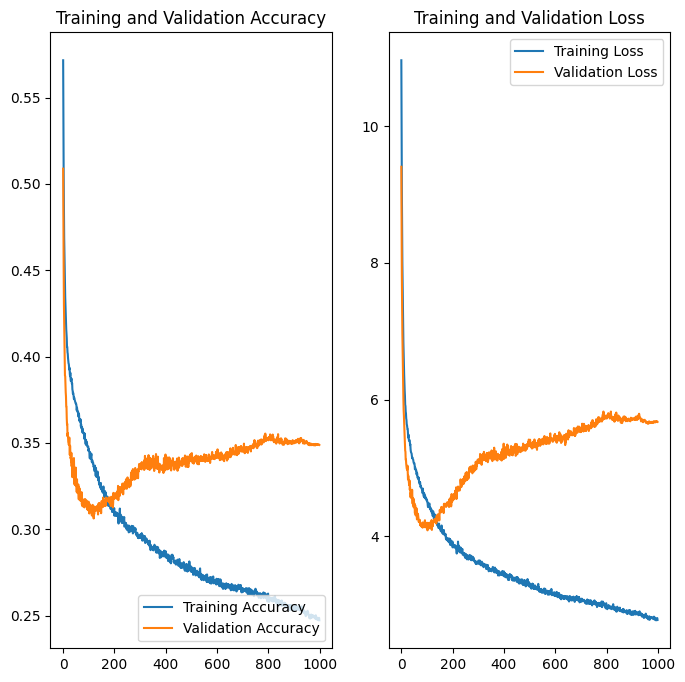

In [31]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

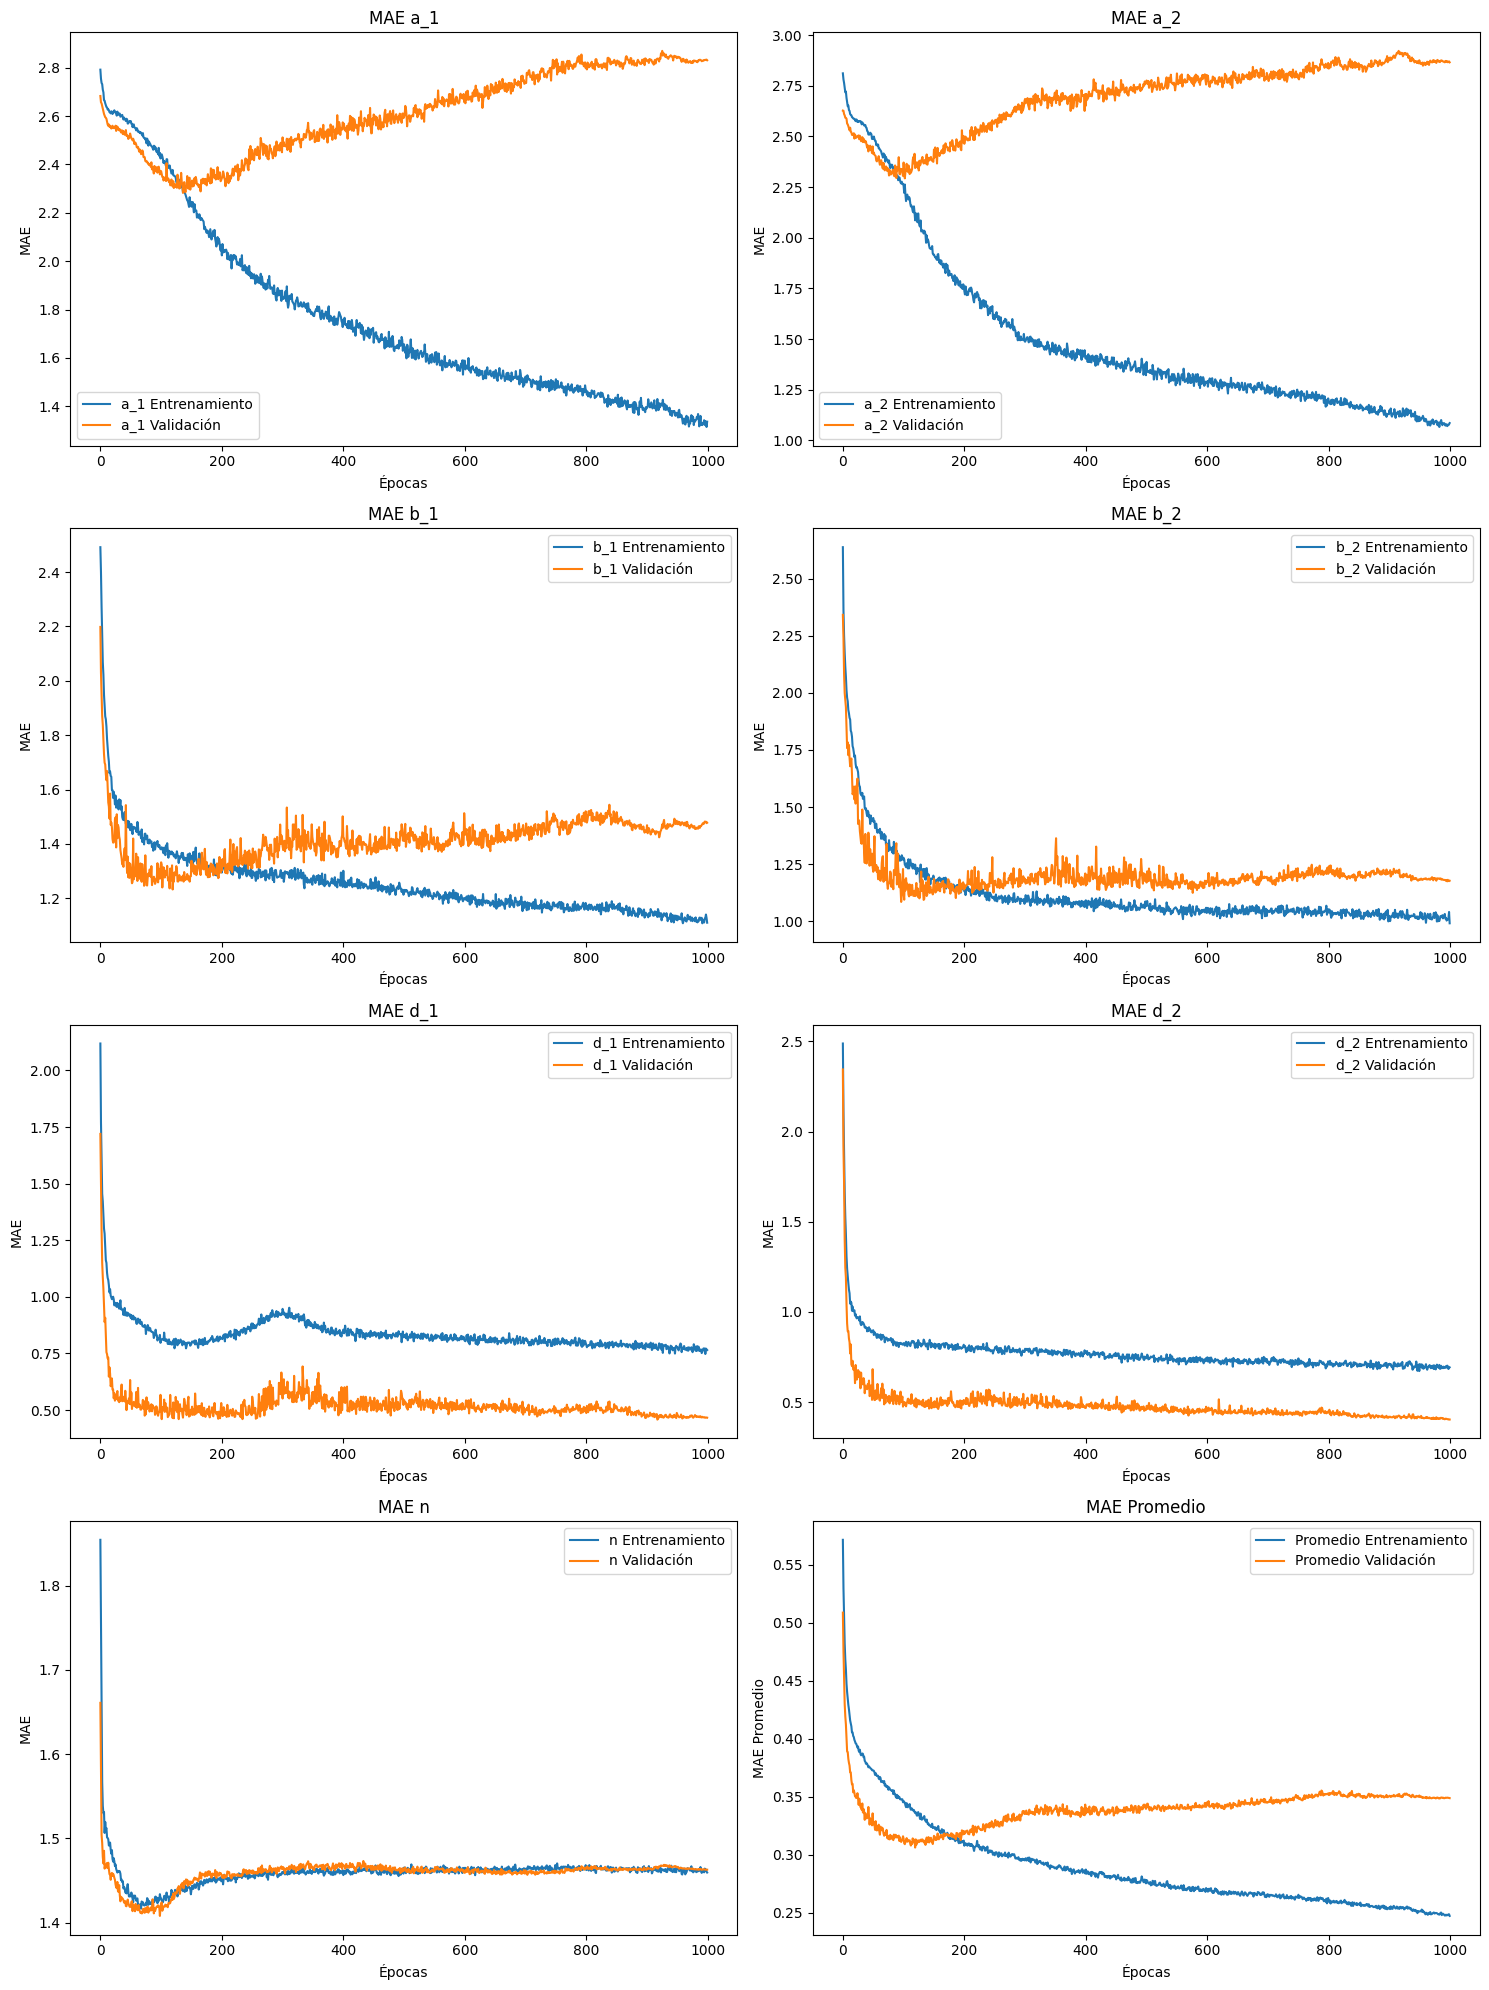

In [32]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [33]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 3ms/step - loss: 5.7495 - a_1: 2.7688 - a_2: 3.0252 - b_1: 1.4242 - b_2: 1.2719 - d_1: 0.4707 - d_2: 0.3975 - n: 1.4643 - mean_metric: 0.3567


In [34]:
predictions = model.predict(varftest)

63/63 [==============================] - 0s 3ms/step


In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.5457850108968432, Desviación estándar del error: 2.266194734660778, Error absoluto máximo: 9.989936492405832


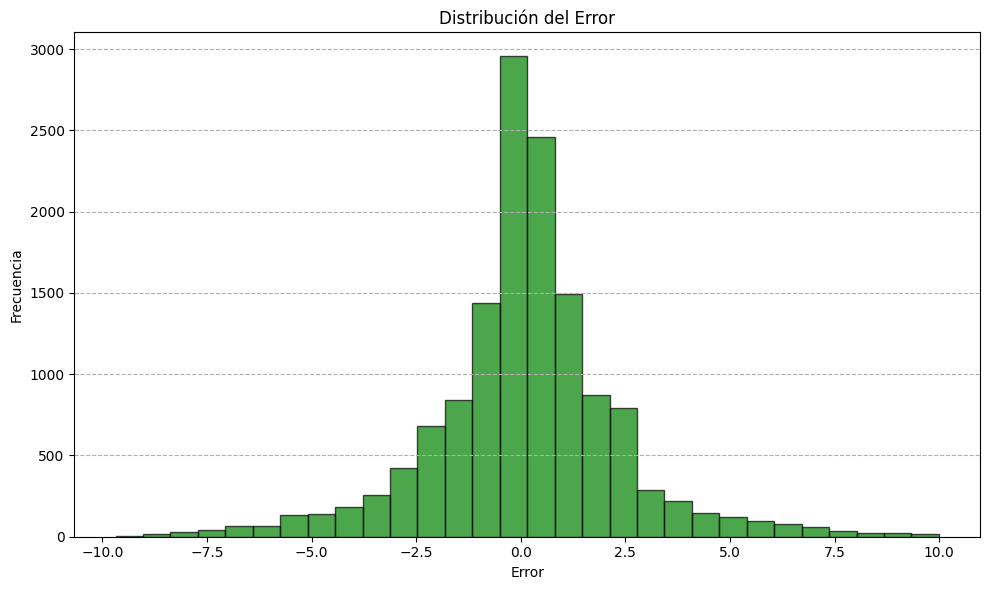

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [37]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

MAE relativo: 0.3546690504787801
Desviación estándar del error relativo: 0.17474309101153904
Error absoluto máximo relativo: 1.8712003827095032


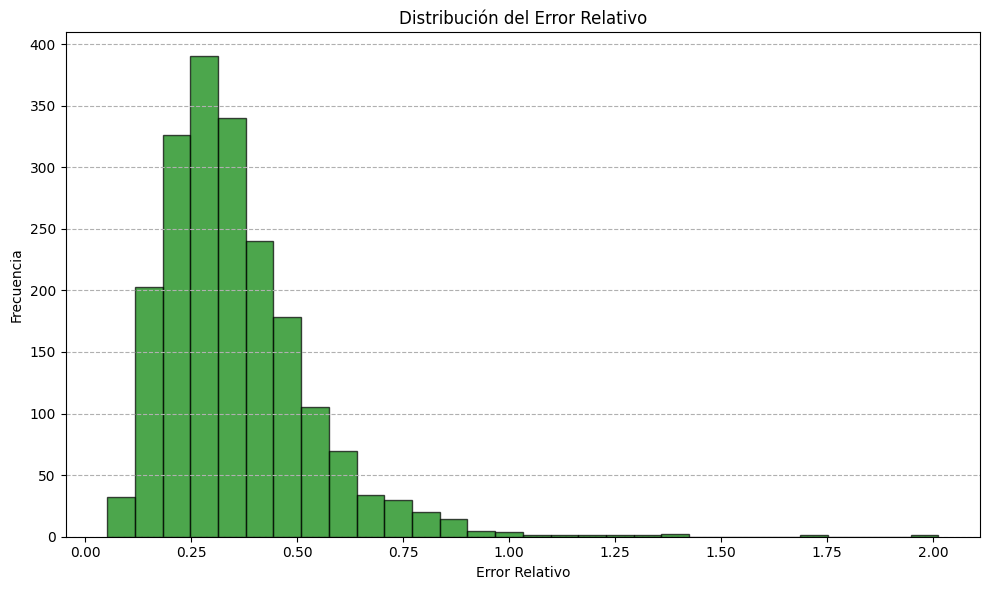

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [39]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 20,50/historyconvtrayec50.csv', index=False)

# Guardamos el modelo

In [40]:
path_to_save = '../../../Modelos con ruido/Modelos 20,50/'

In [41]:
model.save(path_to_save + '/convolucionaltr50.h5')

# Importamos el modelo

In [42]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [43]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [44]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 20,50/convolucionaltr50.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [57]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.1
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 200)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[5, 2, 7, 8, 6, 2, 1]
(10, 2, 50)


In [58]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [59]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 48ms/step
[[ 3.  3.  7. 10.  6.  2.  2.]]


## Graficamos con los coeficientes reales

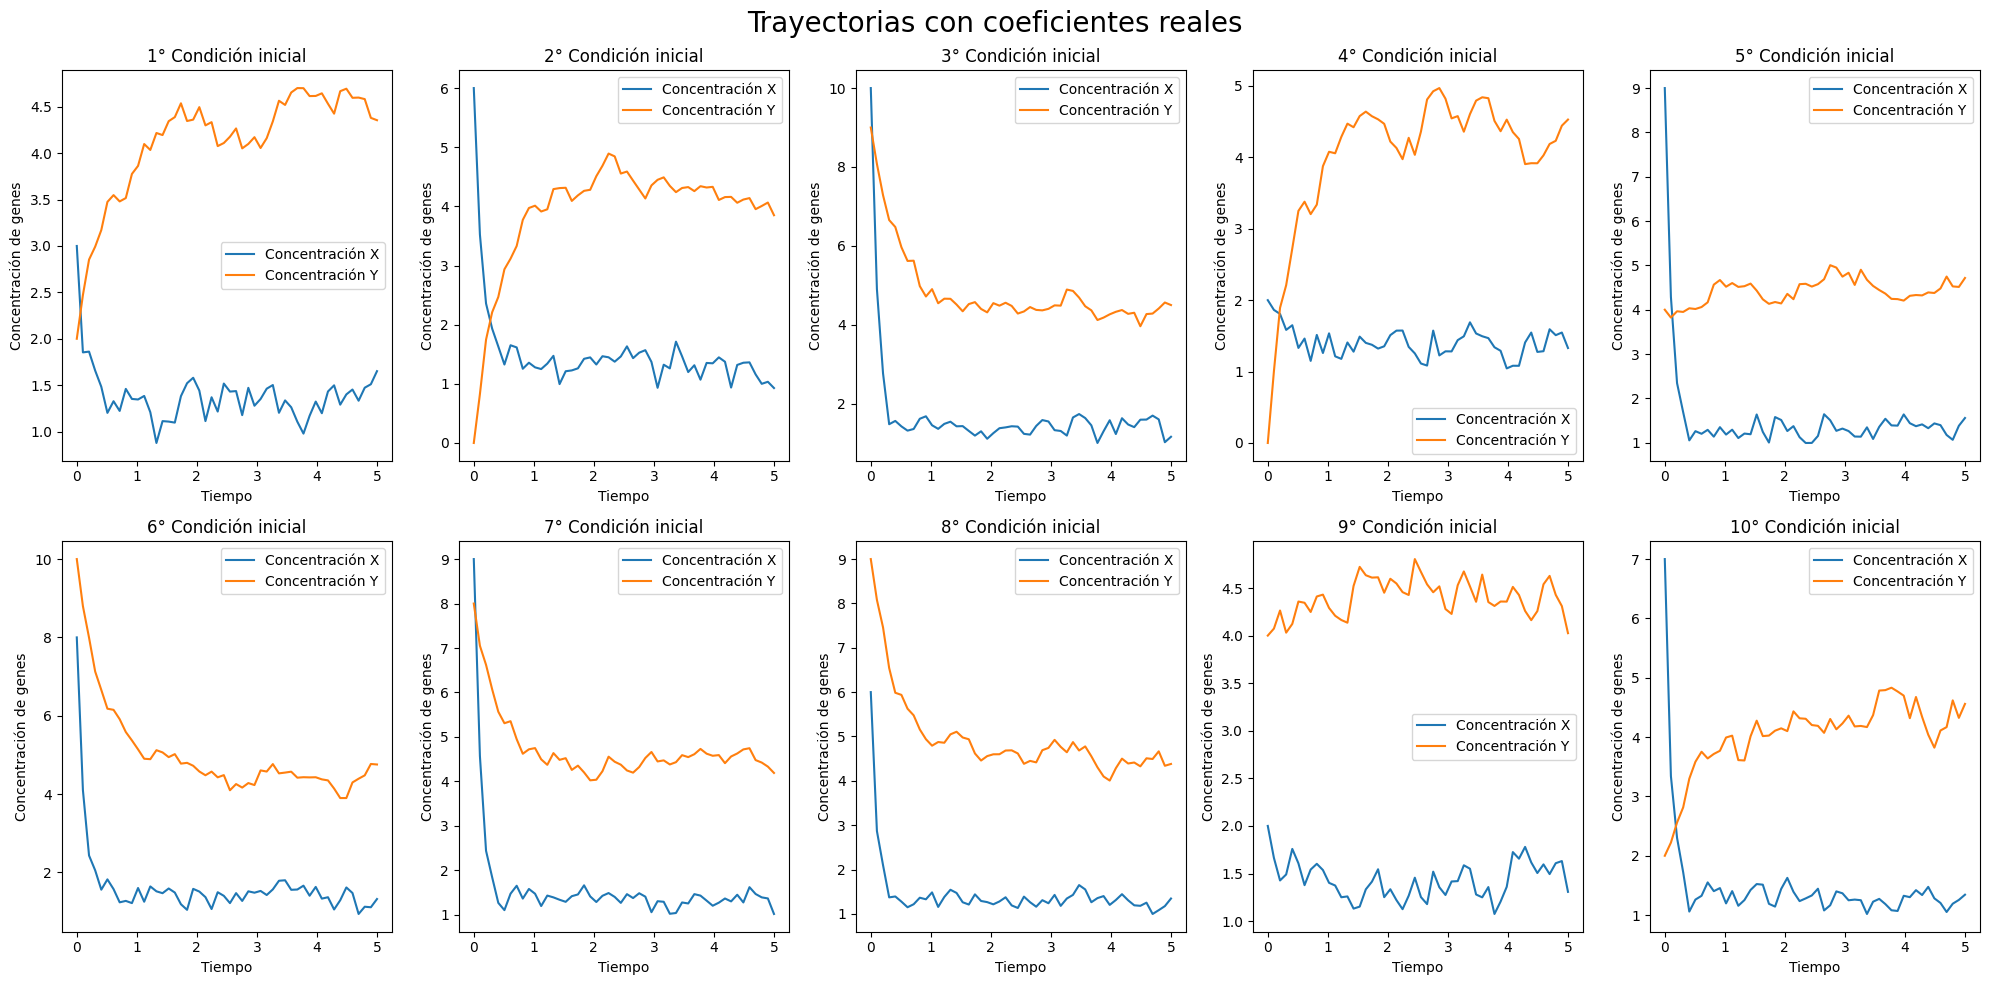

In [60]:
import matplotlib.pyplot as plt

t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [51]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

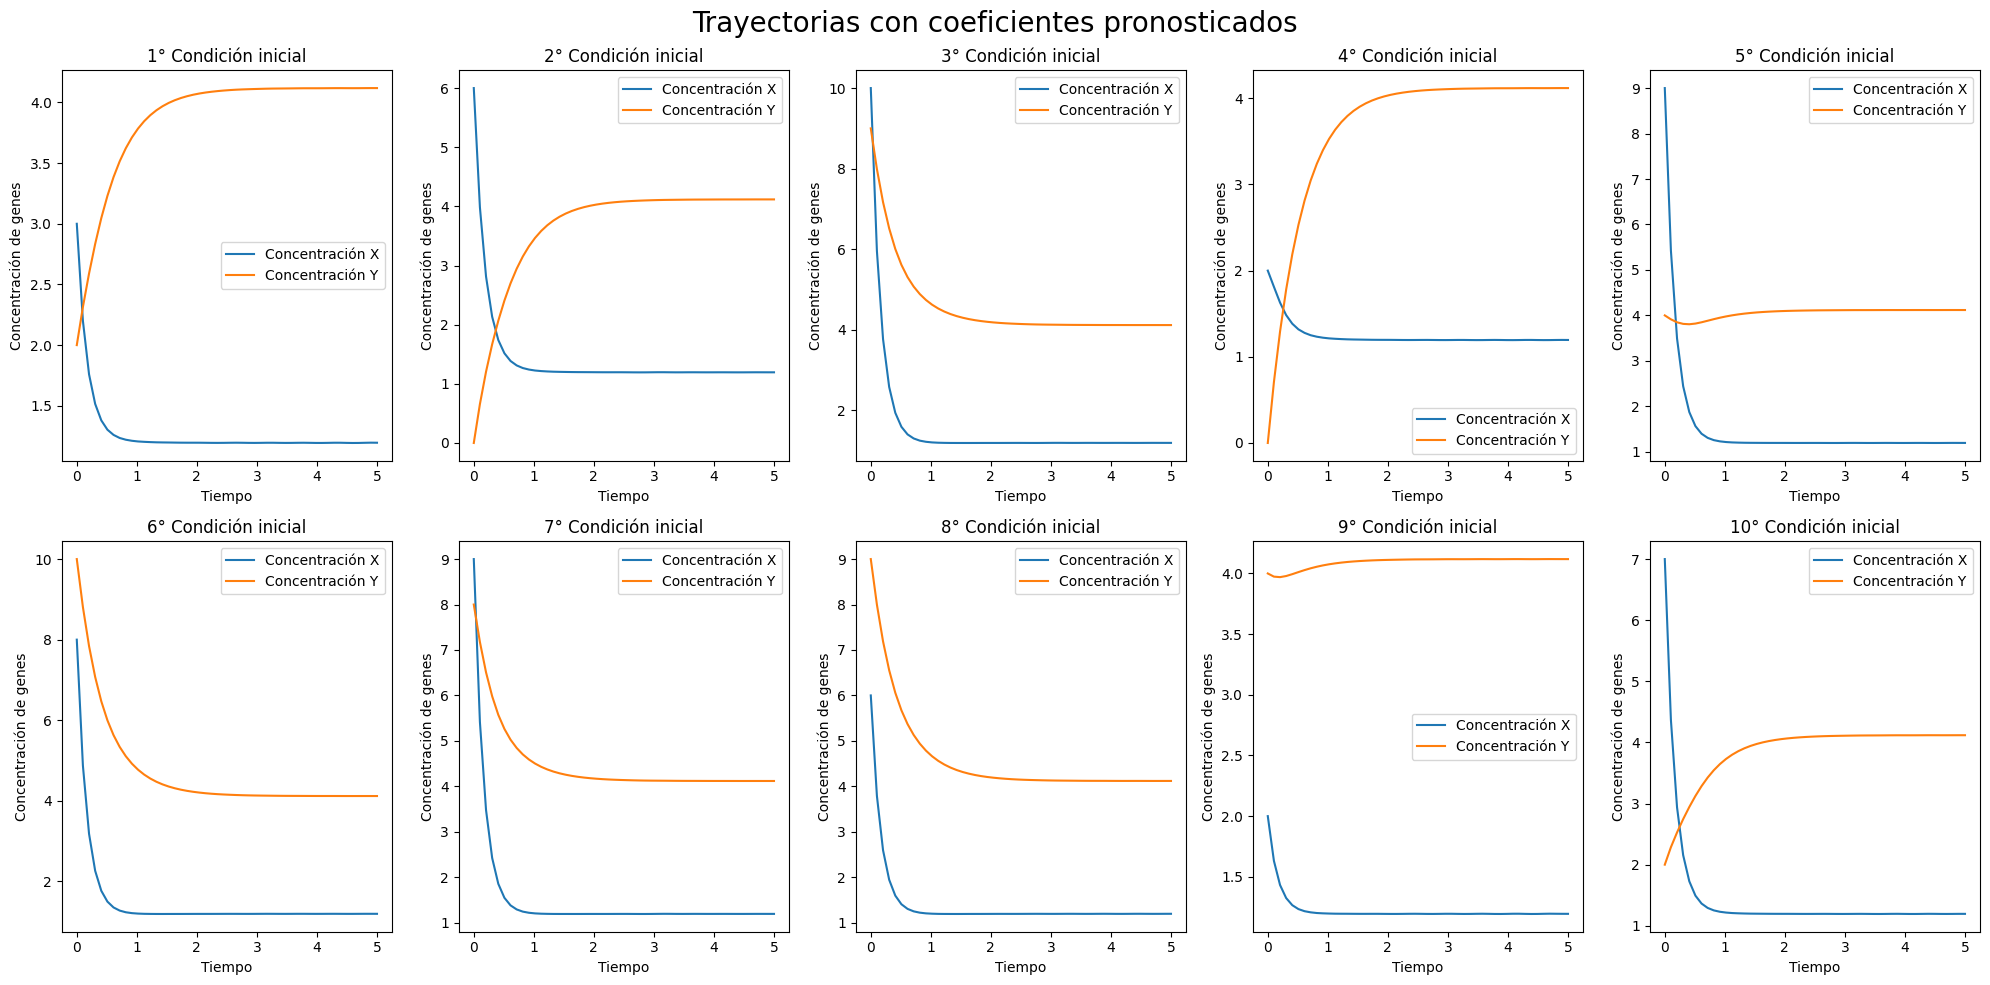

In [61]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

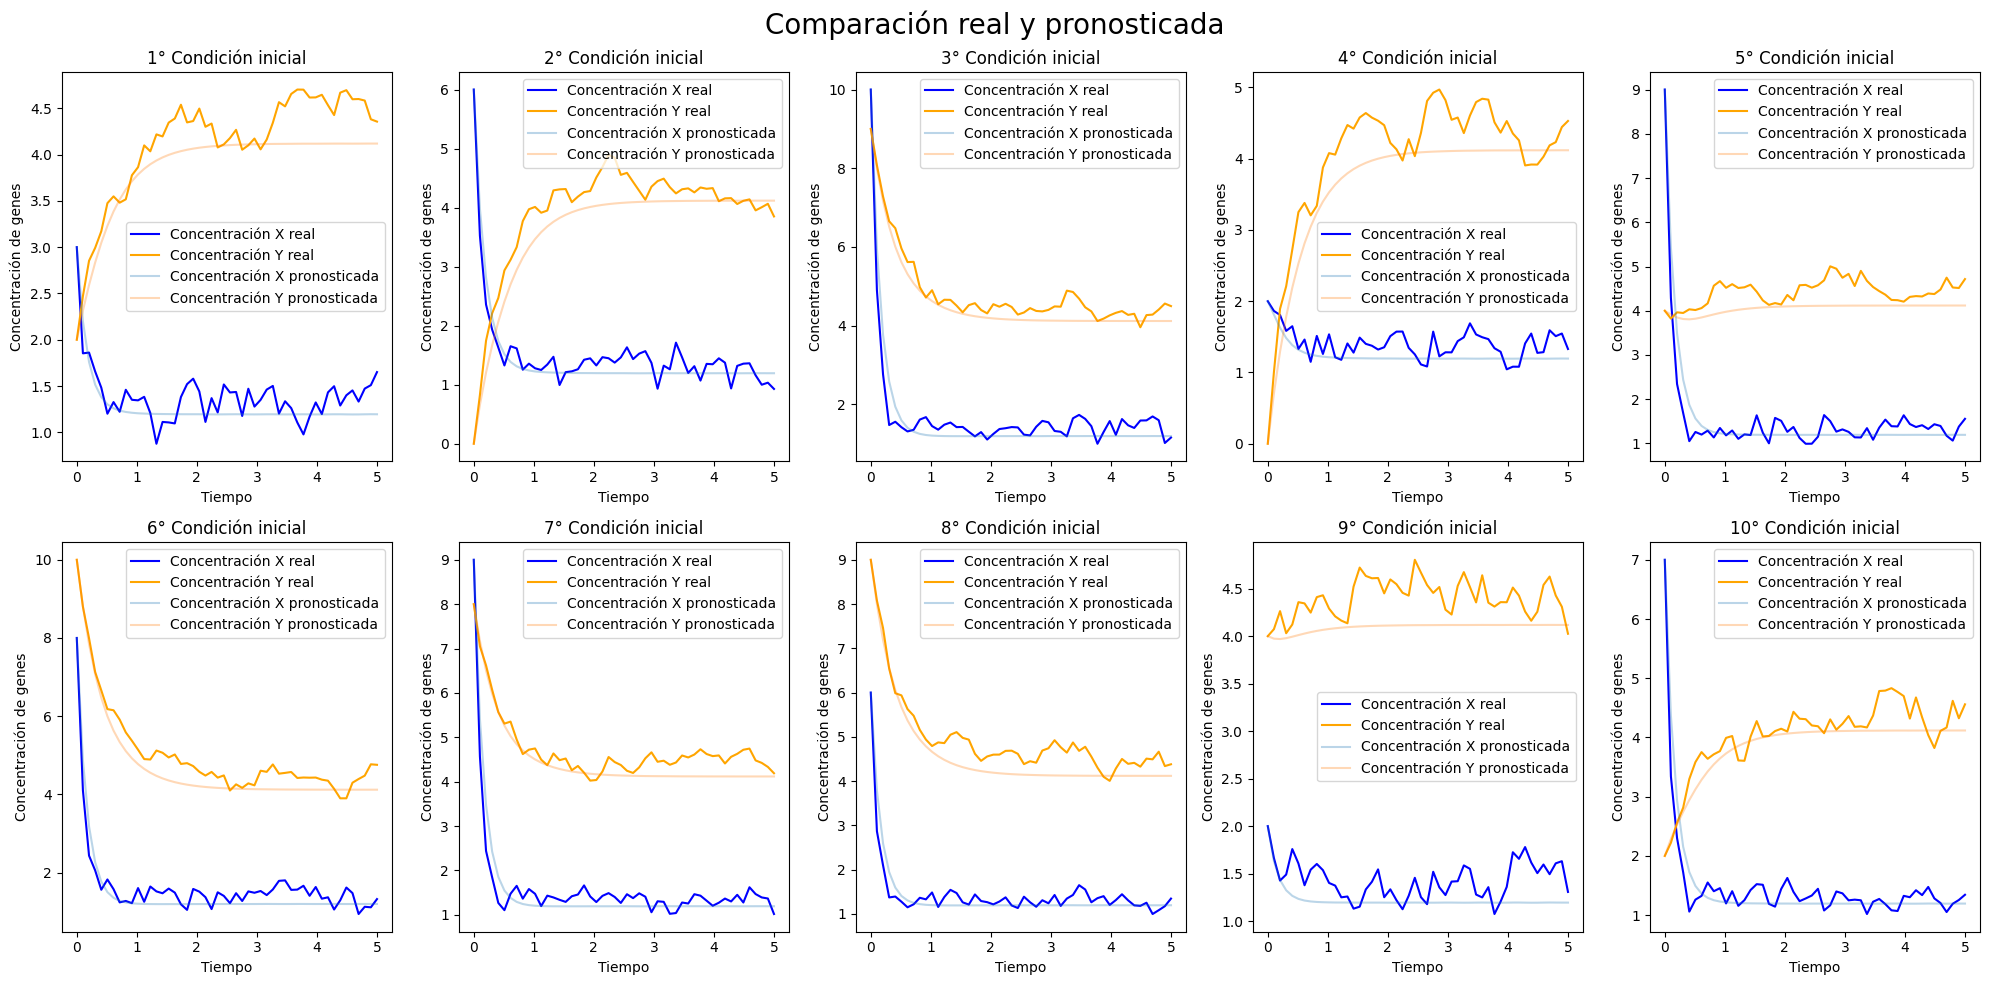

In [63]:
%matplotlib inline
#%matplotlib qt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

# Graficamos las diferencias

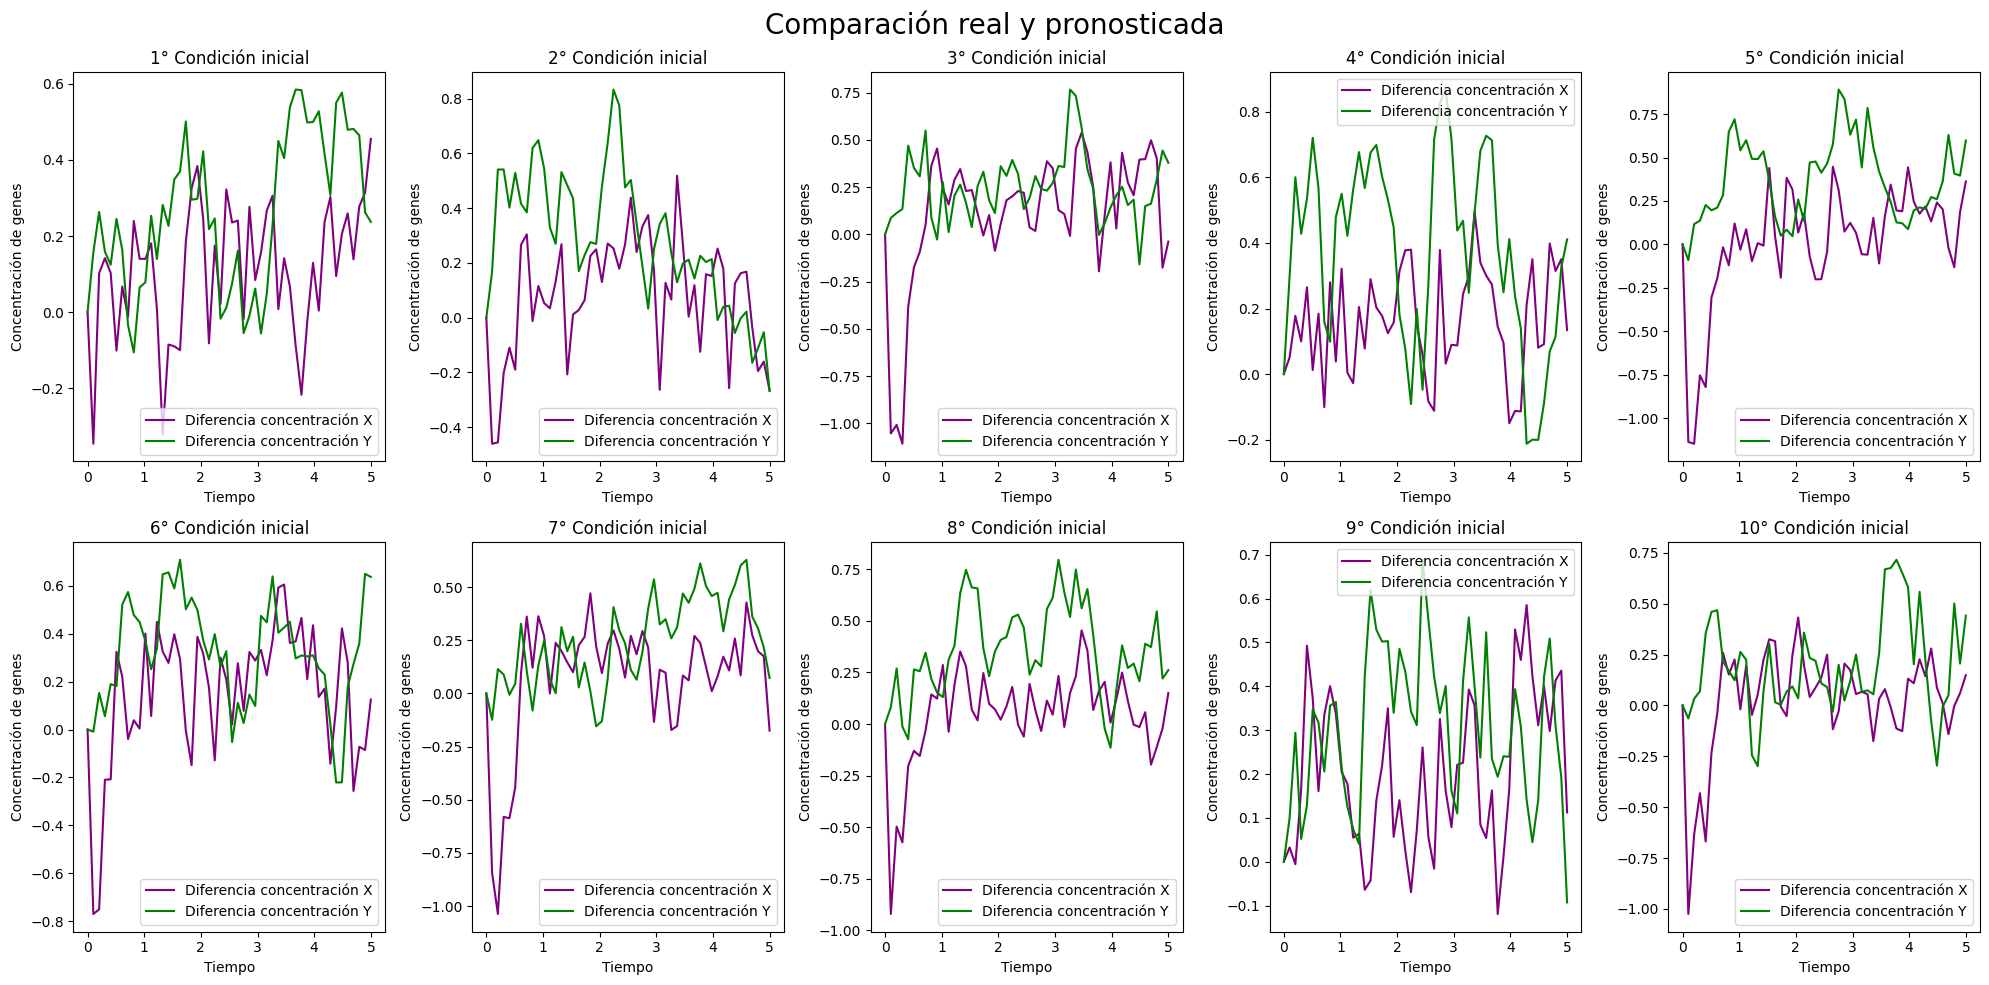

In [64]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 50)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [65]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.052840781821124914
0.07784061709861138
